# Th analysis

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple

import invisible_cities.core.fit_functions as fitf

import invisible_cities.reco.paolina_functions as plf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.xy_algorithms as xy
import invisible_cities.reco.dst_functions as dstf

from   invisible_cities.database import load_db
from   invisible_cities.core.configure         import configure
from   invisible_cities.core.exceptions import SipmEmptyList
from   invisible_cities.core.exceptions import SipmZeroCharge

from   invisible_cities.io.pmap_io             import load_pmaps
from   invisible_cities.reco                   import pmaps_functions  as pmp
from   invisible_cities.evm.event_model        import Hit, Cluster
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from   invisible_cities.core.system_of_units_c import units

from   invisible_cities.filters.s1s2_filter    import s1s2_filter
from   invisible_cities.filters.s1s2_filter    import s2si_filter
from   invisible_cities.filters.s1s2_filter    import S12Selector

In [2]:
# code from Gonzalo
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (1592/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*f.values[1:], *reso(f.values)))

## Reconstruction functions
This functionality will be included in the Penthesilea branch.

In [3]:
DataSiPM        = load_db.DataSiPM(0)
data_xs         = DataSiPM.X.values
data_ys         = DataSiPM.Y.values
#print(DataSiPM)
#print(data_xs)
#print(data_ys)

# histograms to be filled
l_qsipm = []            # all SiPMs
l_qsipm_cluster = []    # all SiPMs within any cluster

l_qsipm_ccenter = []    # the cluster center charges
l_qsipm_qcluster = []   # the cluster energies (same number of entries as l_qsipm_ccenter)

nccenters = 6
l_qsipm_iccenter = []
for n in range(nccenters): l_qsipm_iccenter.append([])

rqmin = 0; rqmax = 70        # charge minima and maxima for charge vs. radius plots
l_q_rlm = []; l_r_rlm = []   # for SiPM charge vs. r within lm_radius
l_q_rnlm = []; l_r_rnlm = [] # for SiPM charge vs. r within new_lm_radius

def barycenter(pos, qs):
    if not len(pos): raise SipmEmptyList
    if sum(qs) == 0: raise SipmZeroCharge
    mu  = np.average( pos           , weights=qs, axis=0)
    std = np.average((pos - mu) ** 2, weights=qs, axis=0)
    return [Cluster(sum(qs), xy(*mu), xy(*std), len(qs))]

def discard_sipms(sis, pos, qs):
    return np.delete(pos, sis, axis=0), np.delete(qs, sis)

def get_nearby_sipm_inds(cs, d, pos, qs):
    """return indices of sipms less than d from (xc,yc)"""
    return np.where(np.linalg.norm(pos - cs, axis=1) <= d)[0]

def corona(pos, qs, Qthr           =  3 * units.pes,
                    Qlm            =  35 * units.pes,
                        lm_radius  = 15.0 * units.mm,
                    new_lm_radius  = 15.0 * units.mm,
                    msipm          =  6):
    """
    corona creates a list of Clusters by
    first , identifying a loc max (gonz wanted more precise than just max sipm)
    second, calling barycenter to find the Cluster given by SiPMs around the max
    third , removing (nondestructively) the sipms contributing to that Cluster
    until there are no more local maxima
    kwargs
    Qthr : SiPMs with less than Qthr pes are ignored
    Qlm  : local maxima must have a SiPM with at least T pes
    lm_radius  : all SiPMs within lm_radius distance from the local max
           SiPM are used (by barycenter) to compute the approximate center
            of the local max.
    new_lm_radius : xs,ys,qs, of SiPMs within new_lm_radius of a local max
           are used by barycenter to compute a Cluster.
    msipm: the minimum number of SiPMs needed to make a cluster
    returns
    c    : a list of Clusters
    """
    c  = []
    # Keep SiPMs with at least Qthr pes
    above_threshold = np.where(qs >= Qthr)[0]
    pos, qs = pos[above_threshold], qs[above_threshold]
    
    if(sum(qs) < 60):
        return []
    
    # While there are more local maxima
    ncenter = 0
    while len(qs) > 0:
        hottest_sipm = np.argmax(qs)       # SiPM with largest Q
        if qs[hottest_sipm] < Qlm: break   # largest Q remaining is negligible

        # find locmax (the baryc of charge in SiPMs less than lm_radius from hottest_sipm)
        within_lm_radius = get_nearby_sipm_inds(pos[hottest_sipm], lm_radius, pos, qs)
        new_local_maximum  = barycenter(pos[within_lm_radius],
                                        qs [within_lm_radius])[0].posxy[0]

        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - pos[hottest_sipm], axis=0)
            if(d < lm_radius and q > rqmin and q < rqmax):
                l_q_rlm.append(q)
                l_r_rlm.append(d)

        # new_lm_radius is an array of the responsive sipms less than
        # new_lm_radius from locmax
        within_new_lm_radius = get_nearby_sipm_inds(new_local_maximum,
                                                    new_lm_radius, pos, qs)
        for q,p in zip(qs,pos):
            d = np.linalg.norm(p - new_local_maximum, axis=0)
            #print("Types are d {0}, q {1}, new_lm_radius {2}, rqmin {3}, rqmax {4}".format(type(d),type(q),type(new_lm_radius),type(rqmin),type(rqmax)))
            if(d < new_lm_radius and q > rqmin and q < rqmax):
                l_q_rnlm.append(q)
                l_r_rnlm.append(d)

        # if there are at least msipms within_new_lm_radius, get the barycenter
        if len(within_new_lm_radius) >= msipm:
            c.extend(barycenter(pos[within_new_lm_radius],
                                qs [within_new_lm_radius]))
            for q in qs[within_new_lm_radius]: l_qsipm_cluster.append(q)
            l_qsipm_ccenter.append(qs[hottest_sipm])
            l_qsipm_qcluster.append(sum(qs))
            if(ncenter < nccenters): l_qsipm_iccenter[ncenter].append(qs[hottest_sipm])
            ncenter += 1

        # delete the SiPMs contributing to this cluster
        pos, qs = discard_sipms(within_new_lm_radius, pos, qs)

    return c

def compute_xy_position(si, slice_no):
    si      = {sipm_no: sipm[slice_no] for sipm_no, sipm in si.items()} #pmp.select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    Qs = np.array(Qs)
    #xs, ys  = data_xs[IDs], data_ys[IDs]
    for q in Qs: l_qsipm.append(q)
    pos = np.array([np.array([x,y]) for x,y in zip(data_xs[IDs],data_ys[IDs])])
    return corona(pos, Qs)

def split_energy(e, clusters):
    if len(clusters) == 1:
        return [e]
    qs = np.array([c.Q for c in clusters])
    return e * qs / np.sum(qs)

## Read the corrections table

7.92
Correction table with shape: (50, 50); bin sizes (7.9199981689453125,7.9199981689453125)


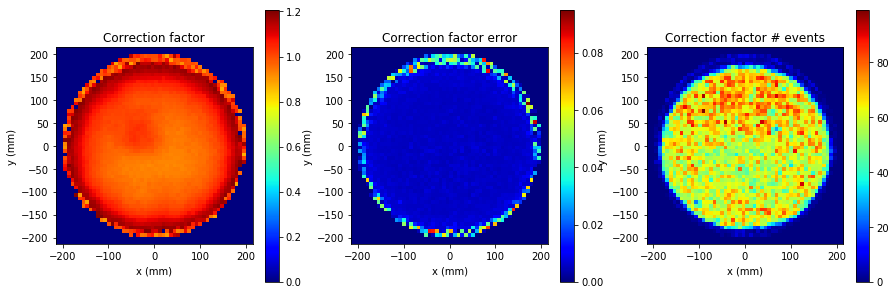

In [4]:
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b10.corr"
#corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/old/mcKr.corr"
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4168/run4168_corrections.h5"
fcorr = tb.open_file(corr_file,'r')

ncbins = 54

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf = np.max(corr_fs)

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor (MC)
ax1 = fig.add_subplot(131);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=maxf)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(132)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(133)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

# get the x and y bin sizes
xdiff = corr_x[1:] - corr_x[0:-1]
nz_xdiff = np.nonzero(xdiff)[0]
xbin = xdiff[nz_xdiff][0]
xcmin = np.min(corr_x)
print(xbin)

ydiff = corr_y[1:] - corr_y[0:-1]
nz_ydiff = np.nonzero(ydiff)[0]
ybin = ydiff[np.nonzero(ydiff)][0]
ycmin = np.min(corr_y)

ctbl = np.ones([len(nz_xdiff)+1,len(nz_xdiff)+1])-2
for x,y,fs in zip(corr_x,corr_y,corr_fs):
    xb = int((x-xcmin)/xbin)
    yb = int((y-ycmin)/ybin)
    ctbl[xb][yb] = fs
    #print("Filled ({0},{1}) with {2} for x = {3} and y = {4}".format(xb,yb,fs,x,y))
if(len(ctbl[ctbl < 0]) > 0):
    print("ERROR: value in correction table not filled")
print("Correction table with shape: {0}; bin sizes ({1},{2})".format(ctbl.shape,xbin,ybin))
    
def fcorr(x,y):
    xb = max(0,min(ctbl.shape[0]-1,((x-xcmin)/xbin).astype(int)))
    yb = max(0,min(ctbl.shape[1]-1,((y-ycmin)/ybin).astype(int)))

    if hasattr(xb, "__len__"):
        cf = [ctbl[xx][yy] for xx,yy in zip(xb,yb)]
        return cf
    else:
        return ctbl[xb][yb]

## Perform initial analysis with a DST

In [5]:
# code from Gonzalo
run_number    = 4484
inputfilename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/dst/dst_{1}.root.h5".format(run_number,run_number)
full = dstf.load_dst(inputfilename, "DST", "Events")
print(len(full))
full.head()

9504


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.499970e+09,0,1,275.0,59.174740,353.042031,847550.0,55.457375,18207.923828,...,1029962.5,476,182.4125,182.4125,-58.229906,81.104390,99.843097,2.193476,45.702965,47.963936
1,3,1.499970e+09,0,1,325.0,76.771904,457.793548,732400.0,56.277750,18307.046875,...,1017012.5,452,284.6125,284.6125,15.476704,140.621437,141.470551,1.461178,50.471513,49.563160
2,5,1.499970e+09,0,1,300.0,85.588783,468.010359,865650.0,79.354250,18597.736328,...,1034887.5,597,169.2375,169.2375,-129.406866,-40.362241,135.555330,-2.839253,59.320594,49.241932
3,6,1.499970e+09,0,1,300.0,124.138268,708.545367,648700.0,73.337500,17789.914062,...,1030162.5,613,381.4625,381.4625,-77.007666,-104.085437,129.475707,-2.207770,50.810358,71.496101
4,7,1.499970e+09,0,2,275.0,77.786621,427.330454,988525.0,117.973250,17468.431641,...,1006412.5,363,17.8875,17.8875,114.734600,-118.843244,165.190027,-0.802986,42.140763,43.704905


Number of events used in histograms = 7779


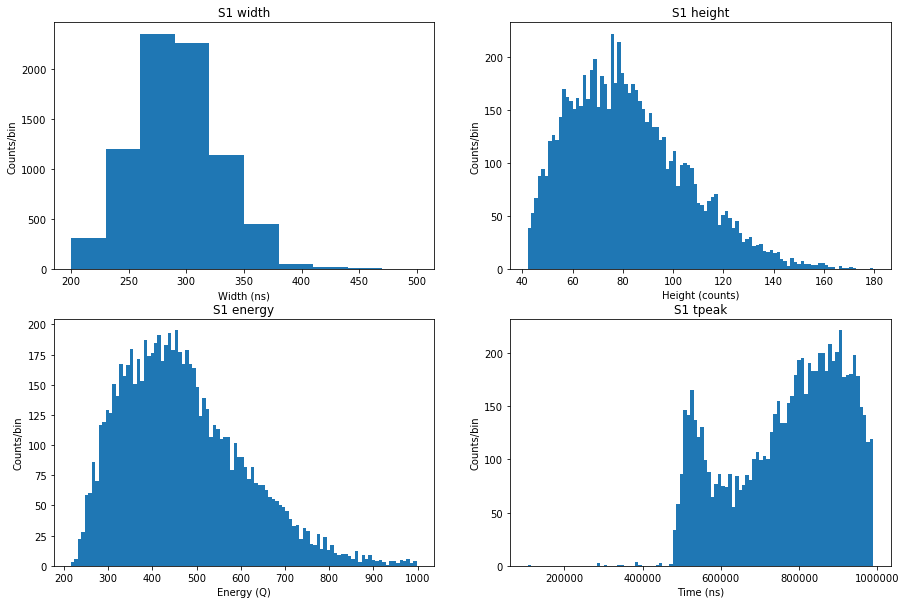

In [6]:
# histograms of quantities of interest (S1)
print("Number of events used in histograms = {0}".format(len(full[full.peak == 0])))
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(full.S1w[full.peak == 0],bins=10)
#lnd = plt.legend(loc=1)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.title('S1 width')
plt.xlabel('Width (ns)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(full.S1h[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 height')
plt.xlabel('Height (counts)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(full.S1e[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 energy')
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(full.S1t[full.peak == 0],bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S1 tpeak')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

Number of events used in histograms = 9504


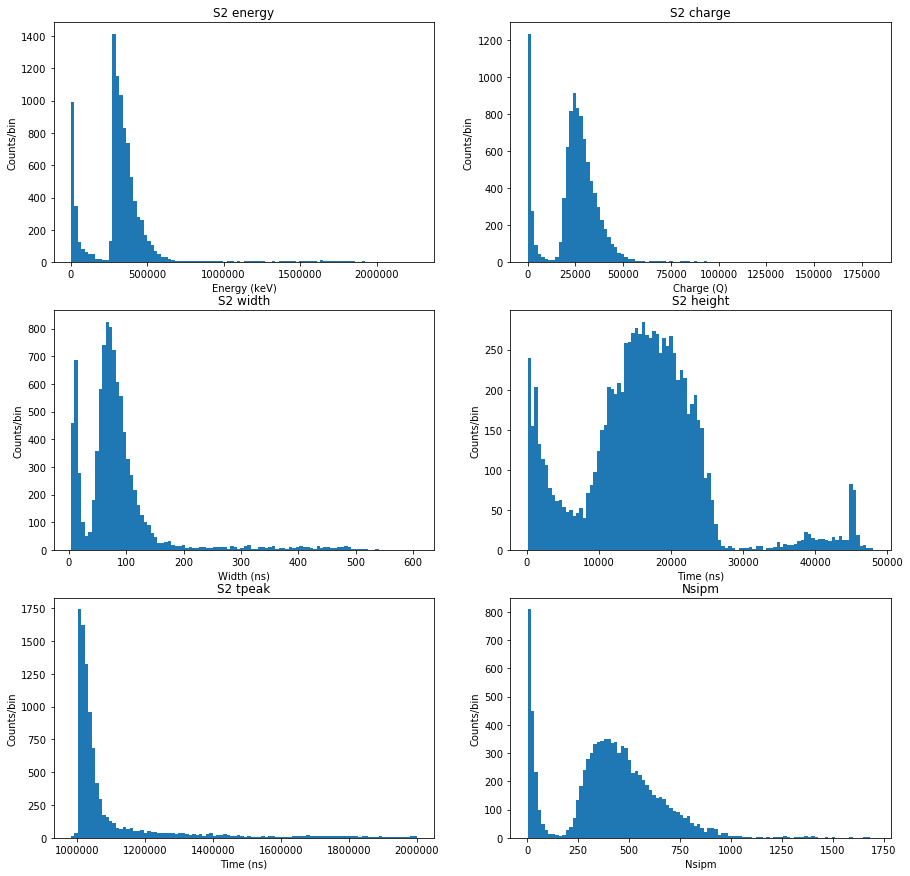

In [7]:
# histograms of quantities of interest (S2)
print("Number of events used in histograms = {0}".format(len(full)))
fig = plt.figure(1)
fig.set_figheight(15.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(321);
plt.hist(full.S2e,bins=100)
#lnd = plt.legend(loc=1)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.title('S2 energy')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(322)
plt.hist(full.S2q,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 charge')
plt.xlabel('Charge (Q)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(323)
plt.hist(full.S2w,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 width')
plt.xlabel('Width (ns)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(324)
plt.hist(full.S2h,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 height')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

ax5 = fig.add_subplot(325)
plt.hist(full.S2t,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('S2 tpeak')
plt.xlabel('Time (ns)')
plt.ylabel('Counts/bin')

ax6 = fig.add_subplot(326)
plt.hist(full.Nsipm,bins=100)
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
#lnd = plt.legend(loc=1)
plt.title('Nsipm')
plt.xlabel('Nsipm')
plt.ylabel('Counts/bin')

In [8]:
# show energy spectrum directly from DST


## Read the PMaps and construct the hit collection for a given event
This will be performed in the future by Penthesilea.

In [9]:
# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_event(l_X,l_Y,l_Q,l_X0,l_Y0):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(20.0)
    fig.set_figwidth(20.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    plt.scatter(l_X,l_Y,c=l_Q)
    plt.colorbar()
#    for xx,yy,qq in zip(l_X,l_Y,l_Q):
#        r = Ellipse(xy=(xx, yy), width=4., height=4.);
#        r.set_facecolor('0');
#        r.set_alpha(qq);
#        ax1.add_artist(r);

    # place a large blue circle for actual EL points
    ax1.scatter(l_X0,l_Y0,marker='x',s=100,color='red')
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

In [26]:
# Configuration information
tot_Emin = 50000; tot_Emax = 1000000
tlife = 1150
cfile = '/Users/jrenner/IFIC/IC-1/invisible_cities/config/s12_selector_4491.conf'

# read the configuration file
conf = configure(['bar', cfile])
_s1s2_selector = S12Selector(**conf.as_dict)

In [11]:
hitc_evt = []; hitc_mc = []; ext1_mc = []; ext2_mc = []
evtnum_hitc = []
#nfiles = 107
print_cut = False
tbl_ri = 0
tot_evts_sum = 0
l_rnums = [4484, 4491] #[4484, 4489, 4491] # [1000]
l_nfiles = [122, 107] #[122, 95, 107] # [1]

for rnum,nfiles in zip(l_rnums,l_nfiles):
    
    print("\n--- RUN {0} ---".format(rnum))
    for ifile in range(nfiles):

        print("File {0} of {1}...".format(ifile,nfiles))

        if(ifile < 10): fstr = "00{0}".format(ifile)
        elif(ifile < 100): fstr = "0{0}".format(ifile)
        else: fstr = "{0}".format(ifile)

        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_{0}_0_7bar_pmaps_10000.root.h5".format(ifile)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/{0}/pmaps/pair_1592keV_z250mm_10evt_pmaps.root.h5".format(rnum)
        filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/pmaps/pmaps.gdcsnext.{1}_{2}.root.h5".format(rnum,fstr,rnum)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3913/pmaps/pmaps.gdcsnext.{0}_3913.root.h5".format(fstr)
        #filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/3755/pmaps/pmaps.gdcsnext.{0}_3755.root.h5".format(fstr)
        if(not os.path.isfile(filename)):
            print("File {0} does not exist. Skipping.".format(ifile))
            continue
        try:
            S1s, S2s, S2Sis = load_pmaps(filename)
        except (ValueError, tb.exceptions.NoSuchNodeError):
            print("Empty file {0}. Skipping.".format(ifile))
        event_numbers, timestamps = get_event_numbers_and_timestamps_from_file_name(filename)
        ftbl = tb.open_file(filename,'r')

        tot_evts_sum += len(event_numbers)
        print("... {0} events in file ({1} total)".format(len(event_numbers), tot_evts_sum))
        for evt_number, evt_time in zip(event_numbers,timestamps):
            #print("Processing event {0}".format(evt_number))
            hitc = []

            s1   = S1s  .get(evt_number, {})
            s2   = S2s  .get(evt_number, {})
            s2si = S2Sis.get(evt_number, {})

            if(not s1 or not s2 or not s2si):
                if(print_cut):
                    print("Skipping event {0}:".format(evt_number))
                    if(not s1): print("-- empty s1")
                    if(not s2): print("-- empty s2")
                    if(not s2si): print("-- empty s2si")
                continue
            if(len(s2.s2d) != len(s2si.s2sid)): 
                if(print_cut): print("Skipping event {0}: length of s2 does not match that of s2si".format(evt_number))
                continue
            #print(type(s2si))
            #print(s2.s2d.keys())
            #print(s2si.s2sid.keys())

            f1 = s1s2_filter(_s1s2_selector, s1, s2, s2si)
            f2 = s2si_filter(s2si)
            if not f1 or not f2:
                continue

            esum = sum([sum(earr) for pnum,(tarr,earr) in sorted(s2.s2d.items())])

            if(not (tot_Emin <= esum <= tot_Emax)):
                if(print_cut): print("Skipping event {0}: did not make energy cuts...".format(evt_number))
            else:
                t, e = next(iter(s1.s1d.values()))
                S1t  = t[np.argmax(e)]
                s2, s2si = pmp.rebin_s2si(s2,s2si,2)
                #S2, Si = rebin_s2(S2, Si)

                npeak = 0
                for peak_no, (t_peak, e_peak) in sorted(s2.s2d.items()):
                    si = s2si.s2sid[peak_no]
                    e_left = 0
                    for slice_no, (t_slice, e_slice) in enumerate(zip(t_peak, e_peak)):
                        #print("Slice number {0}".format(slice_no))
                        incomplete = False
                        for sipm_no,sipm in si.items():
                            if(slice_no >= len(sipm)):
                                incomplete = True
                        if(incomplete):
                            print("WARNING: incomplete charge information for slice ")
                            e_left += e_slice
                        else:
                            clusters = compute_xy_position(si, slice_no)
                            #print("Computed pos")
                            if(len(clusters) == 0):
                                e_left += e_slice
                            else:
                                es       = split_energy(e_slice + e_left, clusters)
                                z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0
                                for c, e in zip(clusters, es):
                                    hit       = Hit(peak_no,c,z,e)
                                    #print("hit at ({0},{1},{2};{3})".format(hit.X,hit.Y,hit.Z,hit.E))
                                    #print("hit at ({0},{1},{2};{3})".format(hit.pos[0],hit.pos[1],hit.pos[2],hit.E))
                                    hitc.append(hit)
                                e_left = 0
                    if(len(hitc) > 0 and e_left > 0):
                        hitc[-1].energy += e_left
                    npeak += 1

                hitc_evt.append(hitc)
                evtnum_hitc.append(evt_number)

                # record MC information if available
                if(ftbl.__contains__('/MC')):
                    hitcm = []
                    mctbl = ftbl.root.MC.MCTracks
                    mcevt = 0; eemax = 0
                    ext1 = np.zeros(3); ext2 = np.zeros(3)
                    #while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['event_indx'] != evt_number):
                    #    tbl_ri += 1
                    #while(tbl_ri < len(mctbl) and mctbl[tbl_ri]['mctrk_indx'] == evt_number):
                    while(tbl_ri < len(mctbl) and (tbl_ri == 0 or mctbl[tbl_ri]['mctrk_indx'] >= mctbl[tbl_ri-1]['mctrk_indx'])):
                        hpos = mctbl[tbl_ri]['hit_position']
                        henergy = mctbl[tbl_ri]['hit_energy']
                        hit = Hit(0,Cluster(0, xy(hpos[0],hpos[1]), xy(0,0), 0),hpos[2],henergy)
                        hitcm.append(hit)
                        if(mctbl[tbl_ri]['particle_name'] == 'e+'):
                            ext1[0] = hpos[0]; ext1[1] = hpos[1]; ext1[2] = hpos[2]
                        elif(mctbl[tbl_ri]['particle_name'] == 'e-' and mctbl[tbl_ri]['energy'] > eemax):
                            ext2[0] = hpos[0]; ext2[1] = hpos[1]; ext2[2] = hpos[2]
                        print("MCTrack index = {0}".format(mctbl[tbl_ri]['mctrk_indx']))
                        tbl_ri += 1
                    hitc_mc.append(hitcm)
                    ext1_mc.append(ext1)
                    ext2_mc.append(ext2)
                    mcevt += 1
                    tbl_ri += 1

        ftbl.close()
    print("Produced hit collections for {0} events ({1} events in MC truth).".format(len(hitc_evt),len(hitc_mc)))


--- RUN 4484 ---
File 0 of 122...
... 112 events in file (112 total)
File 1 of 122...
... 1 events in file (113 total)
File 2 of 122...
... 95 events in file (208 total)
File 3 of 122...
... 112 events in file (320 total)
File 4 of 122...
... 112 events in file (432 total)
File 5 of 122...
... 100 events in file (532 total)
File 6 of 122...
... 111 events in file (643 total)
File 7 of 122...
... 112 events in file (755 total)
File 8 of 122...
... 112 events in file (867 total)
File 9 of 122...
... 112 events in file (979 total)
File 10 of 122...
... 47 events in file (1026 total)
File 11 of 122...
... 112 events in file (1138 total)
File 12 of 122...
... 75 events in file (1213 total)
File 13 of 122...
... 112 events in file (1325 total)
File 14 of 122...
... 16 events in file (1341 total)
File 15 of 122...
... 112 events in file (1453 total)
File 16 of 122...
... 112 events in file (1565 total)
File 17 of 122...
... 111 events in file (1676 total)
File 18 of 122...
... 112 events in 

File 25 of 107...
... 112 events in file (12307 total)
File 26 of 107...
... 112 events in file (12419 total)
File 27 of 107...
... 87 events in file (12506 total)
File 28 of 107...
... 6 events in file (12512 total)
File 29 of 107...
... 112 events in file (12624 total)
File 30 of 107...
... 91 events in file (12715 total)
File 31 of 107...
... 51 events in file (12766 total)
File 32 of 107...
... 105 events in file (12871 total)
File 33 of 107...
... 112 events in file (12983 total)
File 34 of 107...
... 45 events in file (13028 total)
File 35 of 107...
... 65 events in file (13093 total)
File 36 of 107...
... 112 events in file (13205 total)
File 37 of 107...
... 112 events in file (13317 total)
File 38 of 107...
... 31 events in file (13348 total)
File 39 of 107...
... 112 events in file (13460 total)
File 40 of 107...
... 89 events in file (13549 total)
File 41 of 107...
... 12 events in file (13561 total)
File 42 of 107...
... 2 events in file (13563 total)
File 43 of 107...
... 

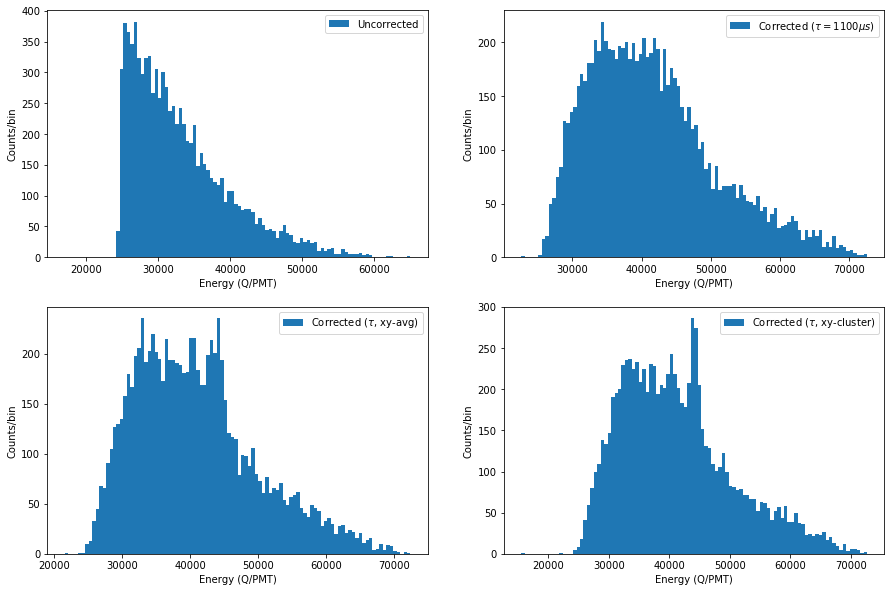

In [12]:
# energy spectrum
npmts = 11
ebins = 100
emin_hist = 150000; emax_hist = 800000
e_spec = []; emc_spec = []; r_spec = []; z_spec = []
ecorr_avg_spec = []; ecorr_tau_spec = []; ecorr_slice_spec = []
for ee in range(len(hitc_evt)):
    evt_E = sum([hh.E for hh in hitc_evt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[ee]])
    if(len(hitc_evt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_Ecorrtau = evt_E/np.exp(-evt_Z/tlife)
    evt_Ecorrtau_xy = evt_Ecorrtau*fcorr(evt_X,evt_Y)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_evt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(ee < len(hitc_mc)): evt_Emc = sum([hh.E for hh in hitc_mc[ee]])
    hr = np.array([np.sqrt(hh.X**2 + hh.Y**2) < 120. for hh in hitc_evt[ee]])
    #print("E = {0}, with tau = {1}, with xy = {2}, with slices = {3}".format(evt_E,evt_Ecorrtau,evt_Ecorrtau_xy,evt_Ecorrtau_xy_slice))
    if(evt_E > emin_hist and evt_E < emax_hist and
       evt_Ecorrtau > emin_hist and evt_Ecorrtau < emax_hist and
       evt_Ecorrtau_xy > emin_hist and evt_Ecorrtau_xy < emax_hist and
       evt_Ecorrtau_xy_slice > emin_hist and evt_Ecorrtau_xy_slice < emax_hist and
       evt_R < 150.): #hr.all()):
        e_spec.append(evt_E)
        r_spec.append(evt_R)
        z_spec.append(evt_Z)
        ecorr_tau_spec.append(evt_Ecorrtau)
        ecorr_avg_spec.append(evt_Ecorrtau_xy)
        ecorr_slice_spec.append(evt_Ecorrtau_xy_slice)
    emc_spec.append(evt_Emc)

e_spec = np.array(e_spec)
ecorr_tau_spec = np.array(ecorr_tau_spec)
ecorr_avg_spec = np.array(ecorr_avg_spec)
ecorr_slice_spec = np.array(ecorr_slice_spec)

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(e_spec/npmts,bins=ebins,label='Uncorrected')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(ecorr_tau_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-avg)'.format(tlife))
#plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$, xy-avg)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-cluster)'.format(tlife))
#plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corr. ($\\tau = {0} \mu s$, xy-cluster)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

In [27]:
# create the corrected hit collection
hitc_cevt = []
for ee in range(len(hitc_evt)):
    hc_corr = []
    for hh in hitc_evt[ee]:
        hecorr = hh.E*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
        hcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
        hc_corr.append(hcorr)
    hitc_cevt.append(hc_corr)

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


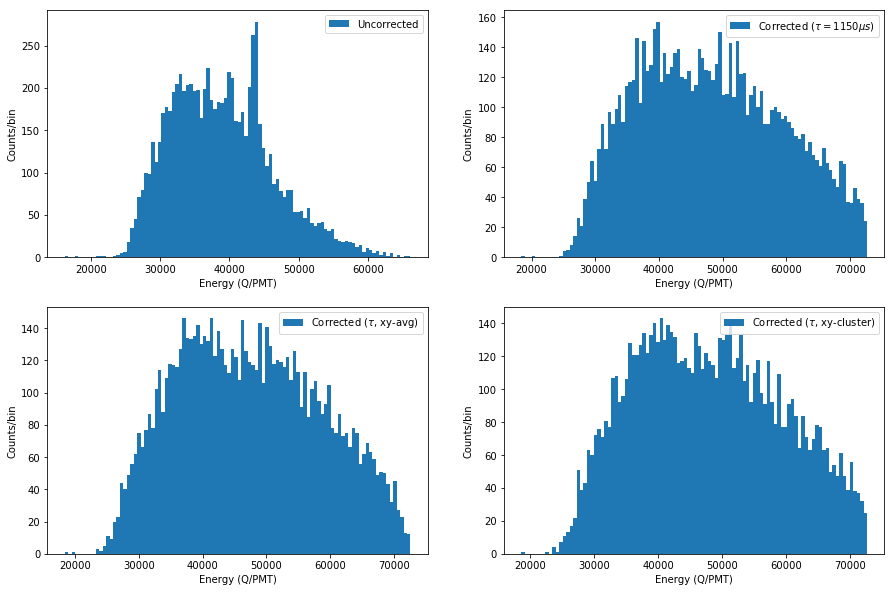

In [28]:
# energy spectrum
ec_spec = []; rc_spec = []; zc_spec = []
eccorr_avg_spec = []; eccorr_tau_spec = []; eccorr_slice_spec = []
for ee in range(len(hitc_cevt)):
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(len(hitc_cevt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_Ecorrtau = evt_E/np.exp(-evt_Z/tlife)
    evt_Ecorrtau_xy = evt_Ecorrtau*fcorr(evt_X,evt_Y)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_cevt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(evt_E > emin_hist and evt_E < emax_hist and
       evt_Ecorrtau > emin_hist and evt_Ecorrtau < emax_hist and
       evt_Ecorrtau_xy > emin_hist and evt_Ecorrtau_xy < emax_hist and
       evt_Ecorrtau_xy_slice > emin_hist and evt_Ecorrtau_xy_slice < emax_hist and
       evt_R < 150.): #hr.all()):
        ec_spec.append(evt_E)
        rc_spec.append(evt_R)
        zc_spec.append(evt_Z)
        eccorr_tau_spec.append(evt_Ecorrtau)
        eccorr_avg_spec.append(evt_Ecorrtau_xy)
        eccorr_slice_spec.append(evt_Ecorrtau_xy_slice)

rc_spec = np.array(rc_spec)
zc_spec = np.array(zc_spec)
ec_spec = np.array(ec_spec)
eccorr_tau_spec = np.array(eccorr_tau_spec)
eccorr_avg_spec = np.array(eccorr_avg_spec)
eccorr_slice_spec = np.array(eccorr_slice_spec)

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(ec_spec/npmts,bins=ebins,label='Uncorrected')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(eccorr_tau_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(eccorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-avg)'.format(tlife))
#plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$, xy-avg)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(eccorr_slice_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-cluster)'.format(tlife))
#plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corr. ($\\tau = {0} \mu s$, xy-cluster)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

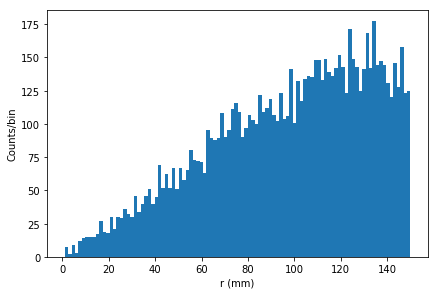

In [29]:
# look at the distribution in r
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

# event distribution vs. R
ax1 = fig.add_subplot(221);
plt.hist(r_spec,bins=100)
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('r (mm)')
plt.ylabel('Counts/bin')

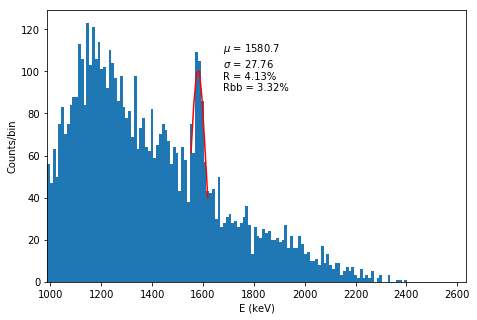

In [87]:
# closer look at the energy spectrum
CAL_FACTOR = 1600/486000
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

#y, x, _ = plt.hist(ecorr_slice_spec, 100, range=[300000,800000])
y, x, _ = plt.hist(ec_spec[zc_spec < 300]*CAL_FACTOR, 150, range=[300000*CAL_FACTOR,800000*CAL_FACTOR])

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 471e3*CAL_FACTOR, 495e3*CAL_FACTOR)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

#plt.hist(ecorr_slice_spec,bins=200)
#plt.ylim([100000,900000])
plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')



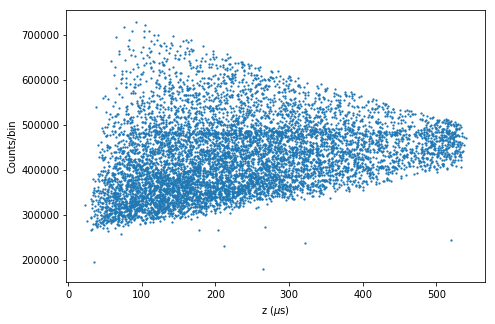

In [53]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.scatter(zc_spec,ec_spec*CAL_FACTOR,s=1.5)
#plt.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
#plt.ylim([100000,900000])
#plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('z ($\\mu$s)')
plt.ylabel('Counts/bin')

# Paolina analysis

In [76]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([15,15,15],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm
ECCUT_LOW = 250000
ECCUT_HIGH = 1000000
DIST_CUT = 100.
EBLOB_CUT = 300000    # do not accept events with a single blob > this energy

In [56]:
# run Paolina for many events
trk_energies = []; 
l_eblob1 = []; l_eblob2 = []; l_eevt = []; l_etrk = []
for nevt in range(len(hitc_cevt)):
    
    hitc = hitc_cevt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[nevt]])
    evt_E = sum([hh.E for hh in hitc_cevt[nevt]])
    if(len(hitc_cevt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    
    # Make energy and radial cuts.
    if(not (evt_E > ECCUT_LOW and evt_E < ECCUT_HIGH) or evt_R >= 150.):
        continue

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    #itmax = np.argmax([len(t) for t in trks])
    itmax = np.argmax([sum([vox.E for vox in t.nodes()]) for t in trks])
    etmax = sum([vox.E for vox in trks[itmax].nodes()])
    
    # voxel fraction cut
    #if(len(trks[itmax])/len(voxels) < 0.95):
    #    continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_evt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add to the distributions if the blob energy does not exceed the upper limit
    if(Eblob1 < EBLOB_CUT and Eblob2 < EBLOB_CUT):
        l_eblob1.append(Eblob1)
        l_eblob2.append(Eblob2)
        l_eevt.append(evt_E)
        l_etrk.append(etmax)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)
l_eevt = np.array(l_eevt)
l_etrk = np.array(l_etrk)

Track 0 with 40 hits...
Track 3 with 50 hits...
Found 3 tracks of 10979; max containing 13 voxels; total of 21 voxels, distance = 135.5719061776573
Track 5 with 29 hits...
Track 6 with 40 hits...
Track 8 with 53 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 24 voxels, distance = 206.6665208345363
Track 9 with 55 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 211.17287049678043
Track 10 with 50 hits...
Found 4 tracks of 10979; max containing 11 voxels; total of 23 voxels, distance = 108.4358323027922
Track 11 with 50 hits...
Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 221.96969104860815
Track 12 with 44 hits...
Found 3 tracks of 10979; max containing 16 voxels; total of 19 voxels, distance = 101.31129697092184
Track 14 with 48 hits...
Found 1 tracks of 10979; max containing 27 voxels; total of 27 voxels, distance = 191.50553383377687
Track 16 with 23 hits...
Track 17 with 28 hits...
Tr

Found 4 tracks of 10979; max containing 19 voxels; total of 26 voxels, distance = 101.91476329879967
Track 153 with 36 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 150.78171129933088
Track 154 with 58 hits...
Found 3 tracks of 10979; max containing 23 voxels; total of 28 voxels, distance = 113.37123433885841
Track 156 with 38 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 20 voxels, distance = 122.08752932242248
Track 159 with 56 hits...
Found 3 tracks of 10979; max containing 12 voxels; total of 25 voxels, distance = 112.35715478890982
Track 160 with 39 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 147.14607694186483
Track 161 with 32 hits...
Track 164 with 32 hits...
Track 166 with 40 hits...
Found 3 tracks of 10979; max containing 13 voxels; total of 20 voxels, distance = 147.21126372513856
Track 168 with 37 hits...
Track 169 with 23 hits...
Track 173 with 40 hits...
Found 2

Track 326 with 25 hits...
Track 328 with 33 hits...
Track 329 with 28 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 124.3970208081129
Track 330 with 37 hits...
Found 4 tracks of 10979; max containing 9 voxels; total of 16 voxels, distance = 104.72067510606841
Track 337 with 42 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 122.1742356290625
Track 338 with 41 hits...
Track 339 with 36 hits...
Track 340 with 36 hits...
Track 341 with 40 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 221.17084229239836
Track 342 with 39 hits...
Found 3 tracks of 10979; max containing 13 voxels; total of 15 voxels, distance = 129.53153743355844
Track 344 with 52 hits...
Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 143.82894612634897
Track 347 with 51 hits...
Found 2 tracks of 10979; max containing 23 voxels; total of 25 voxels, distance = 138

Track 502 with 47 hits...
Track 503 with 59 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 32 voxels, distance = 141.44947208078335
Track 507 with 22 hits...
Track 509 with 35 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 104.64454140769033
Track 511 with 31 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 140.58621776287825
Track 512 with 34 hits...
Track 513 with 45 hits...
Track 515 with 34 hits...
Track 516 with 38 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 158.0223957677759
Track 517 with 30 hits...
Track 520 with 32 hits...
Track 521 with 40 hits...
Track 522 with 35 hits...
Track 523 with 41 hits...
Found 2 tracks of 10979; max containing 12 voxels; total of 17 voxels, distance = 111.40751312128918
Track 524 with 40 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 169.84367264282943
Track

Track 649 with 34 hits...
Track 650 with 41 hits...
Track 651 with 26 hits...
Track 652 with 34 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 150.33014970004018
Track 654 with 44 hits...
Track 655 with 34 hits...
Track 657 with 38 hits...
Track 661 with 28 hits...
Track 662 with 59 hits...
Track 665 with 44 hits...
Track 669 with 29 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 153.0215922253433
Track 670 with 40 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 138.7132692255806
Track 672 with 43 hits...
Found 4 tracks of 10979; max containing 14 voxels; total of 21 voxels, distance = 100.36254263841317
Track 673 with 71 hits...
Track 675 with 33 hits...
Track 678 with 29 hits...
Found 1 tracks of 10979; max containing 12 voxels; total of 12 voxels, distance = 129.11956019227102
Track 679 with 48 hits...
Found 2 tracks of 10979; max containing 23 voxels; tota

Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 100.84310495538591
Track 827 with 46 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 23 voxels, distance = 140.7170859185319
Track 829 with 75 hits...
Found 1 tracks of 10979; max containing 37 voxels; total of 37 voxels, distance = 308.50129661644195
Track 830 with 30 hits...
Track 831 with 39 hits...
Track 833 with 35 hits...
Track 834 with 42 hits...
Track 835 with 55 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 32 voxels, distance = 161.13595720360254
Track 836 with 34 hits...
Track 838 with 63 hits...
Found 4 tracks of 10979; max containing 22 voxels; total of 31 voxels, distance = 184.64276736802208
Track 839 with 34 hits...
Track 840 with 41 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 23 voxels, distance = 208.11667817052432
Track 842 with 35 hits...
Track 843 with 51 hits...
Found 3 tracks of 10979; max containing 20 voxels; total 

Found 2 tracks of 10979; max containing 34 voxels; total of 35 voxels, distance = 278.14993919402156
Track 1000 with 25 hits...
Track 1001 with 31 hits...
Track 1002 with 46 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 121.41339640127498
Track 1003 with 35 hits...
Track 1007 with 41 hits...
Track 1008 with 48 hits...
Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 172.9808744557202
Track 1009 with 44 hits...
Track 1010 with 54 hits...
Track 1011 with 37 hits...
Track 1012 with 51 hits...
Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 114.78382749662643
Track 1014 with 25 hits...
Track 1015 with 36 hits...
Track 1016 with 25 hits...
Track 1017 with 37 hits...
Track 1018 with 47 hits...
Track 1019 with 27 hits...
Track 1020 with 59 hits...
Found 3 tracks of 10979; max containing 27 voxels; total of 33 voxels, distance = 217.1063894814778
Track 1021 with 50 hits...
Found 3 tra

Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 165.2641166112983
Track 1165 with 30 hits...
Track 1166 with 61 hits...
Found 1 tracks of 10979; max containing 33 voxels; total of 33 voxels, distance = 233.613428172437
Track 1167 with 50 hits...
Found 3 tracks of 10979; max containing 22 voxels; total of 26 voxels, distance = 144.9539300971059
Track 1168 with 35 hits...
Track 1169 with 40 hits...
Track 1171 with 44 hits...
Track 1172 with 35 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 147.8725159795747
Track 1173 with 42 hits...
Track 1174 with 43 hits...
Track 1175 with 44 hits...
Track 1176 with 27 hits...
Track 1178 with 49 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 23 voxels, distance = 216.69814071159124
Track 1179 with 45 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 144.47789127863058
Track 1180 with 49 hits...
Found 3 tracks of 109

Track 1334 with 29 hits...
Track 1337 with 32 hits...
Track 1338 with 35 hits...
Track 1340 with 50 hits...
Track 1342 with 57 hits...
Track 1343 with 39 hits...
Track 1345 with 33 hits...
Track 1346 with 51 hits...
Track 1347 with 50 hits...
Found 1 tracks of 10979; max containing 27 voxels; total of 27 voxels, distance = 243.65097283052174
Track 1348 with 32 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 15 voxels, distance = 134.45194860378166
Track 1349 with 33 hits...
Track 1350 with 36 hits...
Track 1351 with 57 hits...
Track 1352 with 25 hits...
Track 1353 with 49 hits...
Found 4 tracks of 10979; max containing 18 voxels; total of 25 voxels, distance = 142.12958852182138
Track 1356 with 34 hits...
Track 1357 with 42 hits...
Track 1358 with 38 hits...
Track 1359 with 57 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 205.84844827080974
Track 1360 with 38 hits...
Found 2 tracks of 10979; max containing 14 voxels; total

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 114.73480045623042
Track 1434 with 37 hits...
Track 1435 with 32 hits...
Track 1437 with 51 hits...
Found 1 tracks of 10979; max containing 26 voxels; total of 26 voxels, distance = 122.35293221969826
Track 1438 with 40 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 128.79523240056486
Track 1439 with 43 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 118.06840030530188
Track 1441 with 34 hits...
Track 1442 with 24 hits...
Found 2 tracks of 10979; max containing 11 voxels; total of 12 voxels, distance = 107.06573654288364
Track 1443 with 31 hits...
Track 1444 with 35 hits...
Track 1445 with 38 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 120.78796253088265
Track 1446 with 33 hits...
Track 1447 with 28 hits...
Track 1448 with 55 hits...
Found 3 tracks of 10979; max containing 20 

Track 1580 with 23 hits...
Track 1582 with 48 hits...
Track 1583 with 54 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 138.606948576721
Track 1584 with 25 hits...
Track 1585 with 33 hits...
Track 1586 with 58 hits...
Found 1 tracks of 10979; max containing 30 voxels; total of 30 voxels, distance = 280.1630195808865
Track 1587 with 51 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 25 voxels, distance = 132.6309188001668
Track 1589 with 37 hits...
Track 1590 with 42 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 102.04950562024507
Track 1591 with 40 hits...
Track 1592 with 39 hits...
Track 1593 with 31 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 130.53871608796766
Track 1594 with 27 hits...
Track 1595 with 35 hits...
Track 1596 with 33 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 149.54952444

Found 4 tracks of 10979; max containing 19 voxels; total of 27 voxels, distance = 119.74365054577794
Track 1738 with 65 hits...
Found 3 tracks of 10979; max containing 16 voxels; total of 31 voxels, distance = 185.9298149128181
Track 1739 with 39 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 116.91361997347678
Track 1740 with 22 hits...
Track 1741 with 29 hits...
Track 1743 with 34 hits...
Found 4 tracks of 10979; max containing 14 voxels; total of 19 voxels, distance = 100.53686520900213
Track 1745 with 39 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 120.72783809935903
Track 1746 with 28 hits...
Track 1747 with 57 hits...
Track 1748 with 34 hits...
Track 1749 with 38 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 110.53322192712255
Track 1750 with 34 hits...
Track 1751 with 43 hits...
Track 1753 with 39 hits...
Found 3 tracks of 10979; max containing 17 v

Found 2 tracks of 10979; max containing 15 voxels; total of 19 voxels, distance = 131.13886926602675
Track 1910 with 49 hits...
Track 1911 with 49 hits...
Found 1 tracks of 10979; max containing 29 voxels; total of 29 voxels, distance = 180.21875055641107
Track 1914 with 42 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 113.13917812415094
Track 1915 with 38 hits...
Track 1916 with 45 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 127.38743083704964
Track 1917 with 41 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 18 voxels, distance = 121.87209150411297
Track 1919 with 37 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 142.14078521959811
Track 1923 with 51 hits...
Found 2 tracks of 10979; max containing 25 voxels; total of 26 voxels, distance = 173.96668918747343
Track 1925 with 42 hits...
Found 2 tracks of 10979; max containing 24 voxels;

Track 2086 with 39 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 165.1899445556363
Track 2087 with 31 hits...
Track 2088 with 44 hits...
Track 2089 with 35 hits...
Track 2090 with 39 hits...
Track 2092 with 35 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 113.64180345896732
Track 2093 with 59 hits...
Found 3 tracks of 10979; max containing 26 voxels; total of 30 voxels, distance = 248.25475938404873
Track 2094 with 29 hits...
Track 2096 with 21 hits...
Track 2098 with 43 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 155.6237664444859
Track 2099 with 36 hits...
Track 2102 with 38 hits...
Track 2104 with 35 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 115.38035916463735
Track 2105 with 35 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 144.50930201467378
Track 2106 with 31

Track 2247 with 32 hits...
Track 2248 with 38 hits...
Track 2250 with 43 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 22 voxels, distance = 137.31058093726037
Track 2252 with 46 hits...
Track 2253 with 60 hits...
Found 2 tracks of 10979; max containing 27 voxels; total of 29 voxels, distance = 143.8599268062629
Track 2254 with 44 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 26 voxels, distance = 117.9347242618235
Track 2255 with 41 hits...
Track 2256 with 38 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 127.83559367288618
Track 2257 with 47 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 152.2354808238672
Track 2258 with 34 hits...
Track 2259 with 37 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 139.6540597439115
Track 2260 with 38 hits...
Track 2263 with 38 hits...
Found 4 tracks of 10979; max containing 15 voxe

Found 3 tracks of 10979; max containing 22 voxels; total of 26 voxels, distance = 165.66663039083483
Track 2386 with 23 hits...
Track 2390 with 58 hits...
Found 1 tracks of 10979; max containing 29 voxels; total of 29 voxels, distance = 233.26038246435922
Track 2391 with 36 hits...
Track 2392 with 37 hits...
Found 3 tracks of 10979; max containing 9 voxels; total of 11 voxels, distance = 100.25269056069115
Track 2394 with 28 hits...
Track 2395 with 38 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 116.31938965877056
Track 2396 with 50 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 116.90034285657799
Track 2398 with 47 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 214.34453004711148
Track 2399 with 42 hits...
Track 2400 with 44 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 23 voxels, distance = 126.02102731639084
Track 2402 with 52 hits.

Track 2534 with 28 hits...
Track 2535 with 39 hits...
Found 3 tracks of 10979; max containing 14 voxels; total of 17 voxels, distance = 112.36452717724097
Track 2536 with 45 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 21 voxels, distance = 107.02231024052833
Track 2538 with 28 hits...
Track 2539 with 41 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 25 voxels, distance = 130.74827542670187
Track 2540 with 55 hits...
Found 2 tracks of 10979; max containing 12 voxels; total of 23 voxels, distance = 124.46697187274567
Track 2541 with 45 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 20 voxels, distance = 104.73647982518999
Track 2542 with 70 hits...
Track 2544 with 36 hits...
Track 2545 with 41 hits...
Found 3 tracks of 10979; max containing 16 voxels; total of 25 voxels, distance = 186.32580102218046
Track 2549 with 39 hits...
Track 2550 with 86 hits...
Found 2 tracks of 10979; max containing 43 voxels; total of 44 voxels,

Track 2686 with 33 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 101.16080099774629
Track 2687 with 31 hits...
Track 2689 with 44 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 18 voxels, distance = 133.22961464842476
Track 2691 with 50 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 130.64206875531414
Track 2692 with 34 hits...
Track 2694 with 31 hits...
Track 2695 with 34 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 155.39347301611335
Track 2697 with 32 hits...
Track 2700 with 48 hits...
Track 2701 with 29 hits...
Track 2702 with 31 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 143.4115406461832
Track 2703 with 40 hits...
Track 2704 with 28 hits...
Track 2705 with 32 hits...
Track 2706 with 41 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 110.50556

Found 1 tracks of 10979; max containing 32 voxels; total of 32 voxels, distance = 228.16053805002912
Track 2851 with 46 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 21 voxels, distance = 152.4598545068838
Track 2852 with 25 hits...
Track 2853 with 75 hits...
Track 2854 with 35 hits...
Track 2855 with 39 hits...
Track 2856 with 41 hits...
Track 2858 with 43 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 23 voxels, distance = 118.92692844558255
Track 2859 with 45 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 195.2320867476268
Track 2861 with 56 hits...
Found 2 tracks of 10979; max containing 25 voxels; total of 29 voxels, distance = 172.2318321930801
Track 2862 with 40 hits...
Found 3 tracks of 10979; max containing 16 voxels; total of 21 voxels, distance = 100.52291798777179
Track 2864 with 64 hits...
Track 2865 with 29 hits...
Track 2866 with 53 hits...
Found 3 tracks of 10979; max containing 27 vox

Found 4 tracks of 10979; max containing 26 voxels; total of 32 voxels, distance = 197.39712291012833
Track 3007 with 51 hits...
Found 3 tracks of 10979; max containing 21 voxels; total of 27 voxels, distance = 154.44966272901775
Track 3008 with 34 hits...
Track 3009 with 47 hits...
Found 1 tracks of 10979; max containing 31 voxels; total of 31 voxels, distance = 245.9403718898018
Track 3011 with 47 hits...
Found 2 tracks of 10979; max containing 26 voxels; total of 27 voxels, distance = 135.18984500600257
Track 3012 with 45 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 23 voxels, distance = 157.34402119748717
Track 3013 with 37 hits...
Track 3014 with 50 hits...
Found 3 tracks of 10979; max containing 22 voxels; total of 25 voxels, distance = 171.23789616610821
Track 3015 with 44 hits...
Track 3019 with 32 hits...
Track 3022 with 34 hits...
Found 2 tracks of 10979; max containing 13 voxels; total of 14 voxels, distance = 132.4632848888551
Track 3023 with 42 hits..

Track 3160 with 41 hits...
Track 3161 with 45 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 25 voxels, distance = 134.50138154792046
Track 3162 with 31 hits...
Track 3163 with 37 hits...
Track 3164 with 32 hits...
Track 3169 with 39 hits...
Track 3171 with 35 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 100.02430462457491
Track 3172 with 46 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 110.81189608162134
Track 3176 with 42 hits...
Track 3178 with 52 hits...
Found 4 tracks of 10979; max containing 22 voxels; total of 28 voxels, distance = 141.5420664133727
Track 3179 with 47 hits...
Found 6 tracks of 10979; max containing 17 voxels; total of 23 voxels, distance = 164.36817949090565
Track 3180 with 27 hits...
Track 3182 with 50 hits...
Found 5 tracks of 10979; max containing 15 voxels; total of 23 voxels, distance = 102.23545429678848
Track 3183 with 60 hits...
Track 3184 with 3

Track 3312 with 29 hits...
Track 3313 with 47 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 110.66553593586015
Track 3315 with 37 hits...
Found 3 tracks of 10979; max containing 20 voxels; total of 22 voxels, distance = 114.26939646809167
Track 3316 with 34 hits...
Track 3317 with 37 hits...
Track 3318 with 33 hits...
Track 3319 with 31 hits...
Track 3322 with 39 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 22 voxels, distance = 103.37109628688279
Track 3325 with 34 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 102.0444806673465
Track 3326 with 54 hits...
Found 3 tracks of 10979; max containing 17 voxels; total of 21 voxels, distance = 139.92440761166486
Track 3329 with 46 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 192.07983408724027
Track 3330 with 40 hits...
Track 3331 with 36 hits...
Track 3332 with 51 hits...
Found 3 tracks of

Track 3476 with 55 hits...
Track 3477 with 45 hits...
Track 3479 with 24 hits...
Track 3482 with 70 hits...
Found 2 tracks of 10979; max containing 37 voxels; total of 38 voxels, distance = 249.24782247436298
Track 3483 with 45 hits...
Track 3484 with 35 hits...
Found 1 tracks of 10979; max containing 13 voxels; total of 13 voxels, distance = 101.47498938172158
Track 3486 with 62 hits...
Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 165.07430603044503
Track 3487 with 31 hits...
Track 3488 with 46 hits...
Track 3489 with 26 hits...
Found 1 tracks of 10979; max containing 11 voxels; total of 11 voxels, distance = 101.24044239258447
Track 3490 with 45 hits...
Track 3491 with 44 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 182.97484924725643
Track 3492 with 36 hits...
Track 3494 with 47 hits...
Track 3495 with 34 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 152.9684

Track 3650 with 45 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 25 voxels, distance = 149.5342533053908
Track 3653 with 62 hits...
Found 2 tracks of 10979; max containing 26 voxels; total of 30 voxels, distance = 106.2231528451925
Track 3654 with 39 hits...
Found 1 tracks of 10979; max containing 26 voxels; total of 26 voxels, distance = 106.8566620802843
Track 3655 with 45 hits...
Found 5 tracks of 10979; max containing 18 voxels; total of 22 voxels, distance = 100.37686594031601
Track 3657 with 36 hits...
Track 3661 with 39 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 104.82852754562926
Track 3662 with 58 hits...
Track 3663 with 35 hits...
Found 3 tracks of 10979; max containing 10 voxels; total of 13 voxels, distance = 108.67092005451784
Track 3664 with 36 hits...
Track 3665 with 35 hits...
Found 2 tracks of 10979; max containing 15 voxels; total of 18 voxels, distance = 104.18793622303151
Track 3666 with 33 hits...

Track 3792 with 30 hits...
Track 3794 with 29 hits...
Found 2 tracks of 10979; max containing 13 voxels; total of 17 voxels, distance = 110.36130104227232
Track 3796 with 50 hits...
Track 3797 with 40 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 129.1392899236218
Track 3798 with 46 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 23 voxels, distance = 108.28274624694656
Track 3800 with 42 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 185.20751348536845
Track 3801 with 42 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 112.66051976982355
Track 3802 with 54 hits...
Found 3 tracks of 10979; max containing 22 voxels; total of 29 voxels, distance = 204.34875924750412
Track 3803 with 27 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 106.1539619291865
Track 3804 with 43 hits...
Track 3805 with 34 hits..

Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 118.56426502116625
Track 3928 with 30 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 122.06890558400667
Track 3929 with 47 hits...
Track 3930 with 38 hits...
Found 3 tracks of 10979; max containing 17 voxels; total of 19 voxels, distance = 134.01281566092564
Track 3931 with 33 hits...
Track 3932 with 32 hits...
Track 3934 with 33 hits...
Track 3937 with 52 hits...
Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 154.8669955142254
Track 3938 with 31 hits...
Track 3939 with 37 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 125.01576480827642
Track 3940 with 37 hits...
Track 3941 with 39 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 117.30198867145235
Track 3943 with 39 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 21 voxels, 

Found 5 tracks of 10979; max containing 28 voxels; total of 37 voxels, distance = 215.268149953602
Track 4071 with 57 hits...
Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 256.82135162191054
Track 4072 with 30 hits...
Track 4073 with 61 hits...
Found 1 tracks of 10979; max containing 32 voxels; total of 32 voxels, distance = 216.1550520758911
Track 4074 with 35 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 117.6755233476045
Track 4077 with 35 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 126.38107363618947
Track 4078 with 40 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 102.37890469897654
Track 4080 with 39 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 19 voxels, distance = 122.66530092120767
Track 4084 with 37 hits...
Found 3 tracks of 10979; max containing 14 voxels; total of 16 voxels, distance =

Track 4219 with 38 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 101.71391510702867
Track 4220 with 28 hits...
Track 4221 with 43 hits...
Track 4222 with 45 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 23 voxels, distance = 181.21526104903518
Track 4223 with 28 hits...
Track 4225 with 29 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 132.88918121199018
Track 4229 with 33 hits...
Track 4230 with 64 hits...
Found 3 tracks of 10979; max containing 22 voxels; total of 35 voxels, distance = 169.4550108996687
Track 4231 with 40 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 105.74725192896629
Track 4232 with 42 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 161.35741698646282
Track 4233 with 30 hits...
Found 2 tracks of 10979; max containing 9 voxels; total of 16 voxels, distance = 103.2062621565327

Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 111.3730705429598
Track 4373 with 35 hits...
Track 4374 with 31 hits...
Track 4375 with 47 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 18 voxels, distance = 115.25477733004458
Track 4376 with 36 hits...
Track 4377 with 41 hits...
Track 4378 with 44 hits...
Track 4379 with 63 hits...
Found 1 tracks of 10979; max containing 31 voxels; total of 31 voxels, distance = 246.17871826032766
Track 4381 with 63 hits...
Found 4 tracks of 10979; max containing 21 voxels; total of 29 voxels, distance = 200.01177420834495
Track 4382 with 26 hits...
Track 4383 with 39 hits...
Found 3 tracks of 10979; max containing 13 voxels; total of 15 voxels, distance = 123.3129155751821
Track 4384 with 46 hits...
Track 4385 with 35 hits...
Found 2 tracks of 10979; max containing 12 voxels; total of 14 voxels, distance = 123.01097889738641
Track 4390 with 52 hits...
Found 2 tracks of 10979; max containing 21 vo

Track 4512 with 34 hits...
Track 4513 with 59 hits...
Found 4 tracks of 10979; max containing 16 voxels; total of 33 voxels, distance = 132.39519225138133
Track 4515 with 30 hits...
Track 4516 with 33 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 110.65722241146176
Track 4517 with 58 hits...
Track 4519 with 69 hits...
Found 1 tracks of 10979; max containing 32 voxels; total of 32 voxels, distance = 188.47575992262043
Track 4520 with 51 hits...
Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 149.1196823796532
Track 4522 with 64 hits...
Track 4524 with 30 hits...
Found 3 tracks of 10979; max containing 13 voxels; total of 15 voxels, distance = 127.4583227122042
Track 4525 with 56 hits...
Track 4527 with 36 hits...
Track 4528 with 53 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 26 voxels, distance = 102.8793392034403
Track 4529 with 64 hits...
Found 1 tracks of 10979; max containing 31 vox

Found 1 tracks of 10979; max containing 32 voxels; total of 32 voxels, distance = 173.86345606480268
Track 4675 with 37 hits...
Track 4676 with 42 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 26 voxels, distance = 123.77974077538309
Track 4678 with 32 hits...
Track 4679 with 47 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 140.3663093575679
Track 4681 with 30 hits...
Track 4682 with 38 hits...
Track 4683 with 48 hits...
Found 2 tracks of 10979; max containing 15 voxels; total of 23 voxels, distance = 150.5436591439737
Track 4684 with 33 hits...
Track 4685 with 35 hits...
Track 4687 with 37 hits...
Track 4688 with 52 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 139.07979402936255
Track 4689 with 43 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 146.92359910542982
Track 4690 with 31 hits...
Track 4692 with 55 hits...
Found 2 tracks of 

Found 3 tracks of 10979; max containing 14 voxels; total of 20 voxels, distance = 100.95071302767579
Track 4831 with 26 hits...
Track 4832 with 39 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 219.7445105442866
Track 4833 with 35 hits...
Track 4836 with 34 hits...
Track 4837 with 37 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 104.87290245527882
Track 4839 with 52 hits...
Track 4840 with 32 hits...
Track 4841 with 52 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 22 voxels, distance = 157.66064499032063
Track 4842 with 27 hits...
Track 4843 with 27 hits...
Track 4844 with 31 hits...
Track 4846 with 35 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 129.6500294141647
Track 4847 with 35 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 120.70818615603649
Track 4849 with 38 hits...
Track 4853 with 43

Track 5013 with 43 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 122.86026344122746
Track 5014 with 47 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 23 voxels, distance = 150.5482627612485
Track 5015 with 33 hits...
Track 5016 with 46 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 193.67685532295914
Track 5017 with 47 hits...
Track 5018 with 47 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 106.96857846199171
Track 5019 with 31 hits...
Track 5022 with 42 hits...
Found 2 tracks of 10979; max containing 23 voxels; total of 24 voxels, distance = 110.17827984925094
Track 5023 with 30 hits...
Track 5024 with 40 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 129.43358399844374
Track 5026 with 35 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 107.050247218807

Found 2 tracks of 10979; max containing 21 voxels; total of 26 voxels, distance = 117.29509028101853
Track 5165 with 49 hits...
Track 5166 with 30 hits...
Track 5169 with 22 hits...
Track 5170 with 37 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 127.19099183383724
Track 5171 with 20 hits...
Track 5172 with 33 hits...
Found 4 tracks of 10979; max containing 10 voxels; total of 20 voxels, distance = 104.97463237672216
Track 5173 with 53 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 29 voxels, distance = 102.65092645290375
Track 5174 with 39 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 151.0217202948284
Track 5175 with 33 hits...
Found 2 tracks of 10979; max containing 13 voxels; total of 14 voxels, distance = 103.54317426119519
Track 5176 with 53 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 29 voxels, distance = 182.79368861102145
Track 5177 with 57 hits.

Track 5323 with 48 hits...
Track 5325 with 39 hits...
Track 5328 with 36 hits...
Found 1 tracks of 10979; max containing 13 voxels; total of 13 voxels, distance = 106.84224354454844
Track 5329 with 37 hits...
Track 5330 with 27 hits...
Track 5331 with 33 hits...
Track 5332 with 33 hits...
Track 5333 with 44 hits...
Track 5334 with 27 hits...
Track 5335 with 20 hits...
Track 5336 with 39 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 23 voxels, distance = 157.0949014198873
Track 5337 with 28 hits...
Track 5339 with 32 hits...
Track 5341 with 27 hits...
Track 5342 with 47 hits...
Track 5343 with 28 hits...
Track 5345 with 38 hits...
Found 3 tracks of 10979; max containing 15 voxels; total of 19 voxels, distance = 107.94999195997036
Track 5347 with 41 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 23 voxels, distance = 130.1268963963839
Track 5348 with 37 hits...
Track 5349 with 29 hits...
Track 5352 with 34 hits...
Track 5353 with 36 hits...
Trac

Found 1 tracks of 10979; max containing 26 voxels; total of 26 voxels, distance = 206.39807355646045
Track 5505 with 37 hits...
Track 5506 with 50 hits...
Track 5508 with 46 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 202.10945810052
Track 5509 with 34 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 161.00957339433978
Track 5510 with 34 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 135.89606993834727
Track 5511 with 41 hits...
Track 5513 with 31 hits...
Found 2 tracks of 10979; max containing 13 voxels; total of 14 voxels, distance = 131.67886665576376
Track 5514 with 45 hits...
Track 5515 with 55 hits...
Found 2 tracks of 10979; max containing 26 voxels; total of 31 voxels, distance = 156.70930334450964
Track 5517 with 30 hits...
Found 1 tracks of 10979; max containing 12 voxels; total of 12 voxels, distance = 110.81382771134939
Track 5518 with 37 hits...

Track 5658 with 48 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 131.0533552055529
Track 5659 with 37 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 123.76830754251705
Track 5661 with 42 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 105.29586865383892
Track 5663 with 47 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 23 voxels, distance = 190.22339925366236
Track 5666 with 46 hits...
Found 3 tracks of 10979; max containing 15 voxels; total of 23 voxels, distance = 193.70922589005923
Track 5669 with 60 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 29 voxels, distance = 122.38947794908819
Track 5672 with 25 hits...
Track 5673 with 37 hits...
Track 5674 with 54 hits...
Found 1 tracks of 10979; max containing 31 voxels; total of 31 voxels, distance = 180.80535512145173
Track 5676 with 37 hits...
Track 5677 with 49 hits.

Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 103.68136095662786
Track 5797 with 34 hits...
Track 5798 with 40 hits...
Track 5801 with 40 hits...
Track 5802 with 26 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 117.11993831443611
Track 5803 with 55 hits...
Found 1 tracks of 10979; max containing 29 voxels; total of 29 voxels, distance = 200.46941683909694
Track 5804 with 38 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 162.85822544751142
Track 5805 with 52 hits...
Found 3 tracks of 10979; max containing 23 voxels; total of 27 voxels, distance = 172.4887997304125
Track 5806 with 32 hits...
Found 2 tracks of 10979; max containing 15 voxels; total of 16 voxels, distance = 107.72264157199825
Track 5807 with 32 hits...
Track 5809 with 40 hits...
Track 5810 with 52 hits...
Found 3 tracks of 10979; max containing 22 voxels; total of 24 voxels, distance = 103.520798596864

Track 5972 with 25 hits...
Track 5974 with 41 hits...
Track 5975 with 27 hits...
Track 5977 with 43 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 158.14579407519005
Track 5978 with 45 hits...
Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 125.4293423467023
Track 5979 with 41 hits...
Track 5982 with 34 hits...
Track 5984 with 32 hits...
Track 5985 with 44 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 148.1450646180599
Track 5986 with 45 hits...
Found 2 tracks of 10979; max containing 27 voxels; total of 28 voxels, distance = 204.77146924442835
Track 5987 with 37 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 150.85001663818804
Track 5989 with 41 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 133.3686390810473
Track 5990 with 27 hits...
Track 5994 with 25 hits...
Track 5995 with 35 

Found 6 tracks of 10979; max containing 15 voxels; total of 24 voxels, distance = 106.33988364210866
Track 6143 with 33 hits...
Track 6145 with 31 hits...
Found 2 tracks of 10979; max containing 11 voxels; total of 14 voxels, distance = 123.0208207730695
Track 6146 with 33 hits...
Track 6148 with 32 hits...
Track 6150 with 39 hits...
Track 6151 with 33 hits...
Track 6156 with 31 hits...
Track 6157 with 37 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 132.3107166304546
Track 6158 with 61 hits...
Found 2 tracks of 10979; max containing 27 voxels; total of 28 voxels, distance = 130.4314012989882
Track 6159 with 35 hits...
Track 6160 with 56 hits...
Found 3 tracks of 10979; max containing 25 voxels; total of 29 voxels, distance = 118.61004736453006
Track 6161 with 37 hits...
Track 6164 with 47 hits...
Found 4 tracks of 10979; max containing 20 voxels; total of 23 voxels, distance = 116.25497378860142
Track 6165 with 48 hits...
Found 1 tracks of 1

Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 110.35481489839974
Track 6310 with 42 hits...
Track 6311 with 32 hits...
Track 6313 with 38 hits...
Track 6314 with 50 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 157.29406956678858
Track 6315 with 59 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 29 voxels, distance = 176.8962775765105
Track 6316 with 37 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 154.94467818455462
Track 6317 with 73 hits...
Found 2 tracks of 10979; max containing 30 voxels; total of 32 voxels, distance = 125.69819152540688
Track 6320 with 30 hits...
Track 6322 with 46 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 162.86867474612848
Track 6323 with 38 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 137.71216967635323
Track 6324 with 33 hits.

Found 2 tracks of 10979; max containing 16 voxels; total of 17 voxels, distance = 136.7464640878136
Track 6458 with 53 hits...
Track 6459 with 56 hits...
Track 6461 with 25 hits...
Track 6462 with 43 hits...
Track 6463 with 43 hits...
Track 6464 with 48 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 29 voxels, distance = 118.23971419073312
Track 6468 with 25 hits...
Track 6470 with 33 hits...
Track 6472 with 32 hits...
Track 6474 with 29 hits...
Track 6477 with 30 hits...
Found 1 tracks of 10979; max containing 13 voxels; total of 13 voxels, distance = 124.9965284117049
Track 6478 with 45 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 130.68895154227303
Track 6479 with 30 hits...
Track 6480 with 48 hits...
Track 6482 with 46 hits...
Track 6483 with 35 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 148.43315664704397
Track 6484 with 28 hits...
Track 6486 with 47 hits...
Track 6488 

Found 4 tracks of 10979; max containing 14 voxels; total of 17 voxels, distance = 125.94622830668644
Track 6634 with 33 hits...
Track 6635 with 38 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 109.33603245995681
Track 6636 with 36 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 150.8683265676298
Track 6637 with 55 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 232.56386936228697
Track 6639 with 41 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 107.90025580652491
Track 6640 with 52 hits...
Found 1 tracks of 10979; max containing 26 voxels; total of 26 voxels, distance = 231.34030544210833
Track 6641 with 40 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 124.47788013695097
Track 6642 with 41 hits...
Track 6643 with 36 hits...
Found 2 tracks of 10979; max containing 21 voxels; 

Track 6784 with 44 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 21 voxels, distance = 133.20420968408905
Track 6785 with 41 hits...
Found 3 tracks of 10979; max containing 21 voxels; total of 23 voxels, distance = 140.1599249091272
Track 6787 with 30 hits...
Track 6788 with 46 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 182.50352082549963
Track 6789 with 58 hits...
Track 6791 with 47 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 18 voxels, distance = 115.10911713409084
Track 6793 with 36 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 116.21775967348113
Track 6795 with 58 hits...
Found 4 tracks of 10979; max containing 22 voxels; total of 32 voxels, distance = 141.74877428709033
Track 6797 with 42 hits...
Track 6798 with 24 hits...
Track 6799 with 35 hits...
Track 6800 with 54 hits...
Found 1 tracks of 10979; max containing 27 voxels; total of 27 voxels, 

Found 3 tracks of 10979; max containing 18 voxels; total of 20 voxels, distance = 146.73729793703973
Track 6934 with 32 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 125.6153140708462
Track 6935 with 40 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 158.39101846266323
Track 6937 with 29 hits...
Track 6938 with 28 hits...
Track 6940 with 52 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 119.48878583387855
Track 6941 with 33 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 100.49226360753875
Track 6942 with 36 hits...
Track 6945 with 44 hits...
Track 6946 with 25 hits...
Track 6947 with 41 hits...
Found 3 tracks of 10979; max containing 17 voxels; total of 19 voxels, distance = 110.93911410405559
Track 6948 with 47 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 24 voxels, distance = 114.115506618868

Track 7100 with 44 hits...
Track 7102 with 33 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 147.57808404154548
Track 7103 with 44 hits...
Found 2 tracks of 10979; max containing 27 voxels; total of 28 voxels, distance = 154.72380591830867
Track 7104 with 35 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 19 voxels, distance = 153.90392615182208
Track 7105 with 38 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 104.28497594102367
Track 7107 with 40 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 153.80008626422944
Track 7108 with 29 hits...
Track 7109 with 30 hits...
Track 7111 with 32 hits...
Track 7113 with 29 hits...
Track 7114 with 36 hits...
Track 7115 with 58 hits...
Found 2 tracks of 10979; max containing 37 voxels; total of 38 voxels, distance = 298.2819444137601
Track 7116 with 39 hits...
Track 7117 with 29 hits...
Track 7119 with 3

Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 145.70714277721896
Track 7242 with 43 hits...
Track 7243 with 28 hits...
Track 7244 with 35 hits...
Track 7245 with 67 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 33 voxels, distance = 102.45583758391454
Track 7246 with 39 hits...
Found 3 tracks of 10979; max containing 10 voxels; total of 18 voxels, distance = 116.15294612011428
Track 7248 with 45 hits...
Track 7249 with 39 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 100.19633241107402
Track 7251 with 50 hits...
Found 2 tracks of 10979; max containing 23 voxels; total of 27 voxels, distance = 112.69266180957412
Track 7252 with 32 hits...
Track 7253 with 51 hits...
Found 3 tracks of 10979; max containing 17 voxels; total of 22 voxels, distance = 140.96276840606143
Track 7254 with 38 hits...
Track 7256 with 40 hits...
Found 3 tracks of 10979; max containing 20 voxels; total of 23 voxels,

Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 123.43306291674632
Track 7411 with 38 hits...
Track 7412 with 69 hits...
Track 7413 with 39 hits...
Track 7414 with 30 hits...
Track 7415 with 36 hits...
Found 3 tracks of 10979; max containing 12 voxels; total of 15 voxels, distance = 102.73323475910128
Track 7417 with 30 hits...
Track 7418 with 46 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 183.42154583794678
Track 7420 with 67 hits...
Found 1 tracks of 10979; max containing 31 voxels; total of 31 voxels, distance = 336.28896299851226
Track 7421 with 43 hits...
Found 3 tracks of 10979; max containing 21 voxels; total of 23 voxels, distance = 149.00930943733792
Track 7422 with 48 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 165.31685997325116
Track 7423 with 49 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 28 voxels, distance = 113.80779765538

Track 7568 with 52 hits...
Found 2 tracks of 10979; max containing 26 voxels; total of 27 voxels, distance = 157.29400101060554
Track 7569 with 40 hits...
Track 7572 with 35 hits...
Track 7574 with 32 hits...
Track 7576 with 31 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 122.53101740293715
Track 7578 with 34 hits...
Track 7579 with 43 hits...
Track 7580 with 33 hits...
Track 7581 with 29 hits...
Track 7582 with 35 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 18 voxels, distance = 109.98188972589895
Track 7583 with 36 hits...
Track 7584 with 35 hits...
Track 7585 with 33 hits...
Track 7587 with 53 hits...
Found 4 tracks of 10979; max containing 19 voxels; total of 29 voxels, distance = 191.5655155098654
Track 7588 with 55 hits...
Found 1 tracks of 10979; max containing 23 voxels; total of 23 voxels, distance = 168.50164388405312
Track 7589 with 59 hits...
Found 1 tracks of 10979; max containing 32 voxels; total of 32 v

Track 7734 with 38 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 117.47280435431244
Track 7736 with 33 hits...
Track 7737 with 33 hits...
Track 7738 with 50 hits...
Track 7739 with 26 hits...
Track 7740 with 45 hits...
Track 7741 with 33 hits...
Track 7743 with 30 hits...
Track 7744 with 33 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 119.51853169684904
Track 7745 with 44 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 138.42465151925083
Track 7746 with 46 hits...
Track 7748 with 40 hits...
Track 7750 with 34 hits...
Track 7751 with 33 hits...
Found 2 tracks of 10979; max containing 17 voxels; total of 18 voxels, distance = 110.7389012006927
Track 7752 with 25 hits...
Track 7753 with 39 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 132.28277862706045
Track 7754 with 37 hits...
Found 1 tracks of 10979; max containi

Track 7898 with 36 hits...
Track 7902 with 40 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 163.19359545192395
Track 7903 with 43 hits...
Found 3 tracks of 10979; max containing 20 voxels; total of 24 voxels, distance = 202.1530579468524
Track 7904 with 37 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 141.9339673256373
Track 7906 with 28 hits...
Track 7909 with 32 hits...
Found 1 tracks of 10979; max containing 13 voxels; total of 13 voxels, distance = 104.54568792259089
Track 7910 with 29 hits...
Track 7912 with 26 hits...
Track 7914 with 52 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 163.2520322463117
Track 7915 with 34 hits...
Track 7916 with 28 hits...
Track 7917 with 38 hits...
Track 7918 with 56 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 31 voxels, distance = 150.9384019154376
Track 7920 with 38 hits...
Track 7921 with 34 h

Track 8075 with 37 hits...
Track 8076 with 30 hits...
Track 8078 with 37 hits...
Track 8079 with 30 hits...
Track 8080 with 38 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 148.86544100381263
Track 8082 with 37 hits...
Track 8083 with 22 hits...
Track 8085 with 30 hits...
Track 8086 with 59 hits...
Found 1 tracks of 10979; max containing 33 voxels; total of 33 voxels, distance = 120.40285364568163
Track 8090 with 51 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 100.89298251425538
Track 8091 with 42 hits...
Track 8092 with 44 hits...
Track 8093 with 47 hits...
Track 8094 with 32 hits...
Track 8095 with 31 hits...
Track 8096 with 38 hits...
Track 8099 with 37 hits...
Track 8100 with 38 hits...
Track 8101 with 57 hits...
Found 3 tracks of 10979; max containing 18 voxels; total of 27 voxels, distance = 167.54218149038172
Track 8102 with 37 hits...
Found 4 tracks of 10979; max containing 13 voxels; total

Found 2 tracks of 10979; max containing 17 voxels; total of 29 voxels, distance = 102.89213745708767
Track 8282 with 39 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 151.80376010118027
Track 8283 with 54 hits...
Found 2 tracks of 10979; max containing 24 voxels; total of 25 voxels, distance = 220.5208311217994
Track 8285 with 51 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 25 voxels, distance = 171.10382180262482
Track 8286 with 31 hits...
Track 8287 with 43 hits...
Track 8289 with 36 hits...
Track 8290 with 31 hits...
Found 2 tracks of 10979; max containing 15 voxels; total of 16 voxels, distance = 126.21372422263096
Track 8291 with 55 hits...
Track 8292 with 43 hits...
Track 8293 with 45 hits...
Track 8294 with 38 hits...
Track 8295 with 35 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 122.15060911777255
Track 8296 with 37 hits...
Track 8298 with 34 hits...
Found 1 tracks of

Found 1 tracks of 10979; max containing 42 voxels; total of 42 voxels, distance = 314.4779522633841
Track 8442 with 54 hits...
Track 8443 with 37 hits...
Track 8445 with 49 hits...
Found 3 tracks of 10979; max containing 17 voxels; total of 26 voxels, distance = 109.2890131187657
Track 8446 with 36 hits...
Track 8448 with 45 hits...
Track 8450 with 62 hits...
Found 2 tracks of 10979; max containing 23 voxels; total of 24 voxels, distance = 228.0892416648558
Track 8451 with 26 hits...
Track 8452 with 32 hits...
Found 3 tracks of 10979; max containing 11 voxels; total of 15 voxels, distance = 100.77887393501213
Track 8454 with 34 hits...
Track 8456 with 25 hits...
Track 8457 with 48 hits...
Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 225.49043848753286
Track 8458 with 34 hits...
Track 8459 with 37 hits...
Track 8462 with 38 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 110.44169864382752
Track 8463 with 28 

Found 3 tracks of 10979; max containing 38 voxels; total of 41 voxels, distance = 174.29026713933482
Track 8615 with 36 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 154.29882788174694
Track 8616 with 27 hits...
Found 2 tracks of 10979; max containing 11 voxels; total of 13 voxels, distance = 105.43974542586817
Track 8617 with 42 hits...
Track 8618 with 28 hits...
Track 8619 with 49 hits...
Track 8620 with 36 hits...
Track 8622 with 38 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 15 voxels, distance = 107.01611966489949
Track 8624 with 36 hits...
Track 8625 with 26 hits...
Track 8626 with 36 hits...
Track 8628 with 46 hits...
Found 4 tracks of 10979; max containing 19 voxels; total of 28 voxels, distance = 109.98017897311925
Track 8629 with 39 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 109.97840269020097
Track 8630 with 68 hits...
Found 3 tracks of 10979; max containing 24 

Found 1 tracks of 10979; max containing 13 voxels; total of 13 voxels, distance = 134.41435586181768
Track 8785 with 35 hits...
Track 8786 with 41 hits...
Track 8787 with 42 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 21 voxels, distance = 121.95889313863145
Track 8788 with 21 hits...
Track 8789 with 38 hits...
Track 8791 with 32 hits...
Track 8793 with 32 hits...
Track 8795 with 51 hits...
Found 1 tracks of 10979; max containing 29 voxels; total of 29 voxels, distance = 188.774231395145
Track 8796 with 35 hits...
Track 8797 with 29 hits...
Track 8799 with 32 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 111.462650738462
Track 8802 with 40 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 175.4646387896302
Track 8803 with 36 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 103.42653460403416
Track 8804 with 49 hits...
Found 1 tracks of 109

Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 151.1049608821899
Track 8965 with 32 hits...
Track 8966 with 43 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 116.87656209549318
Track 8968 with 39 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 100.47421814486327
Track 8970 with 57 hits...
Found 3 tracks of 10979; max containing 20 voxels; total of 22 voxels, distance = 205.6556660951626
Track 8971 with 33 hits...
Track 8972 with 41 hits...
Track 8973 with 39 hits...
Track 8974 with 35 hits...
Track 8975 with 52 hits...
Found 4 tracks of 10979; max containing 18 voxels; total of 31 voxels, distance = 152.35592964924726
Track 8976 with 54 hits...
Found 1 tracks of 10979; max containing 24 voxels; total of 24 voxels, distance = 117.91746391687346
Track 8977 with 37 hits...
Found 2 tracks of 10979; max containing 19 voxels; total of 20 voxels, distance = 128.7138488628826

Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 110.2208384369095
Track 9141 with 42 hits...
Found 3 tracks of 10979; max containing 17 voxels; total of 21 voxels, distance = 110.69751647936141
Track 9142 with 33 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 135.447039608105
Track 9143 with 59 hits...
Found 2 tracks of 10979; max containing 27 voxels; total of 28 voxels, distance = 310.0244374720472
Track 9144 with 34 hits...
Track 9145 with 32 hits...
Found 1 tracks of 10979; max containing 12 voxels; total of 12 voxels, distance = 103.77483996852897
Track 9147 with 57 hits...
Track 9149 with 81 hits...
Found 1 tracks of 10979; max containing 34 voxels; total of 34 voxels, distance = 348.9302323208602
Track 9150 with 26 hits...
Track 9151 with 40 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 144.0482145169957
Track 9152 with 37 hits...
Track 9153 with 30 hits...
Fo

Track 9290 with 33 hits...
Track 9291 with 29 hits...
Track 9292 with 31 hits...
Track 9293 with 41 hits...
Found 1 tracks of 10979; max containing 20 voxels; total of 20 voxels, distance = 115.83045835555592
Track 9294 with 38 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 126.98997130111746
Track 9296 with 74 hits...
Found 1 tracks of 10979; max containing 45 voxels; total of 45 voxels, distance = 190.12410751312655
Track 9297 with 40 hits...
Track 9298 with 31 hits...
Track 9300 with 44 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 145.52687908354073
Track 9301 with 34 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 19 voxels, distance = 115.05299117421737
Track 9304 with 31 hits...
Track 9306 with 41 hits...
Found 1 tracks of 10979; max containing 21 voxels; total of 21 voxels, distance = 118.47162084908067
Track 9307 with 26 hits...
Found 1 tracks of 10979; max containing 12 

Track 9438 with 56 hits...
Found 2 tracks of 10979; max containing 26 voxels; total of 28 voxels, distance = 192.09022231278635
Track 9439 with 41 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 101.84680678072331
Track 9442 with 35 hits...
Found 3 tracks of 10979; max containing 12 voxels; total of 14 voxels, distance = 128.14372688419954
Track 9443 with 38 hits...
Track 9444 with 28 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 107.00392985939834
Track 9447 with 24 hits...
Track 9448 with 47 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 100.44899158392782
Track 9450 with 44 hits...
Found 2 tracks of 10979; max containing 16 voxels; total of 20 voxels, distance = 133.6919075700967
Track 9451 with 51 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 164.3276653597597
Track 9453 with 49 hits...
Track 9454 with 43 hits..

Found 2 tracks of 10979; max containing 16 voxels; total of 18 voxels, distance = 121.27550913326381
Track 9620 with 32 hits...
Track 9622 with 69 hits...
Track 9623 with 56 hits...
Found 1 tracks of 10979; max containing 31 voxels; total of 31 voxels, distance = 228.03872986832684
Track 9625 with 54 hits...
Found 1 tracks of 10979; max containing 25 voxels; total of 25 voxels, distance = 206.73954419503985
Track 9626 with 26 hits...
Track 9628 with 34 hits...
Track 9629 with 31 hits...
Track 9631 with 49 hits...
Found 2 tracks of 10979; max containing 22 voxels; total of 24 voxels, distance = 113.36745032497562
Track 9632 with 30 hits...
Track 9634 with 40 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 120.7763002301754
Track 9636 with 39 hits...
Track 9637 with 40 hits...
Found 2 tracks of 10979; max containing 26 voxels; total of 27 voxels, distance = 177.28337283229342
Track 9638 with 30 hits...
Track 9640 with 28 hits...
Track 9641 with 5

Found 2 tracks of 10979; max containing 24 voxels; total of 25 voxels, distance = 180.62048450710932
Track 9806 with 45 hits...
Found 2 tracks of 10979; max containing 18 voxels; total of 19 voxels, distance = 124.79171927759131
Track 9807 with 29 hits...
Track 9808 with 40 hits...
Track 9809 with 29 hits...
Track 9810 with 77 hits...
Found 3 tracks of 10979; max containing 32 voxels; total of 34 voxels, distance = 216.2169269926647
Track 9811 with 34 hits...
Track 9813 with 34 hits...
Track 9814 with 36 hits...
Track 9815 with 46 hits...
Track 9816 with 50 hits...
Found 3 tracks of 10979; max containing 25 voxels; total of 29 voxels, distance = 225.94349181249265
Track 9817 with 46 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 113.02613306779101
Track 9818 with 25 hits...
Track 9819 with 42 hits...
Found 3 tracks of 10979; max containing 21 voxels; total of 25 voxels, distance = 110.75473063773813
Track 9822 with 52 hits...
Found 1 tracks of

Found 1 tracks of 10979; max containing 28 voxels; total of 28 voxels, distance = 207.2520897986065
Track 9957 with 32 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 104.45978022479218
Track 9959 with 55 hits...
Found 1 tracks of 10979; max containing 27 voxels; total of 27 voxels, distance = 102.48327004305042
Track 9960 with 38 hits...
Track 9961 with 33 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 127.39948292337304
Track 9962 with 54 hits...
Found 1 tracks of 10979; max containing 26 voxels; total of 26 voxels, distance = 117.16243090732026
Track 9964 with 46 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 21 voxels, distance = 165.0627976344191
Track 9965 with 29 hits...
Track 9966 with 40 hits...
Track 9967 with 45 hits...
Found 3 tracks of 10979; max containing 14 voxels; total of 27 voxels, distance = 175.9291763893786
Track 9968 with 32 hits...
Track 9969 with 41 hits...

Track 10113 with 54 hits...
Track 10115 with 44 hits...
Track 10117 with 33 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 113.36325256406043
Track 10118 with 57 hits...
Found 3 tracks of 10979; max containing 29 voxels; total of 31 voxels, distance = 199.47431746803363
Track 10119 with 39 hits...
Track 10121 with 39 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 165.01302177120567
Track 10122 with 43 hits...
Track 10123 with 34 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 15 voxels, distance = 129.56328166618584
Track 10124 with 30 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 117.07664753467152
Track 10125 with 44 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 141.93507683573566
Track 10126 with 34 hits...
Track 10127 with 42 hits...
Found 2 tracks of 10979; max containing 18 voxels; total o

Track 10263 with 31 hits...
Track 10264 with 32 hits...
Track 10265 with 36 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 136.00518797011244
Track 10266 with 41 hits...
Found 2 tracks of 10979; max containing 21 voxels; total of 22 voxels, distance = 139.9523806124166
Track 10267 with 47 hits...
Found 3 tracks of 10979; max containing 17 voxels; total of 19 voxels, distance = 113.64651222235725
Track 10268 with 32 hits...
Track 10269 with 41 hits...
Track 10271 with 46 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 104.9502314874025
Track 10273 with 42 hits...
Found 1 tracks of 10979; max containing 19 voxels; total of 19 voxels, distance = 127.2329318359516
Track 10274 with 38 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 131.2004318157397
Track 10275 with 36 hits...
Found 1 tracks of 10979; max containing 18 voxels; total of 18 voxels, distance = 131.0111

Found 3 tracks of 10979; max containing 23 voxels; total of 25 voxels, distance = 145.07969040205924
Track 10397 with 34 hits...
Track 10398 with 60 hits...
Found 3 tracks of 10979; max containing 22 voxels; total of 24 voxels, distance = 153.00188213470642
Track 10400 with 65 hits...
Found 3 tracks of 10979; max containing 14 voxels; total of 28 voxels, distance = 134.53812340130668
Track 10401 with 41 hits...
Track 10402 with 32 hits...
Track 10403 with 36 hits...
Track 10404 with 38 hits...
Found 2 tracks of 10979; max containing 14 voxels; total of 15 voxels, distance = 146.75810210305787
Track 10405 with 46 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 124.53848862417591
Track 10406 with 34 hits...
Found 2 tracks of 10979; max containing 15 voxels; total of 18 voxels, distance = 125.122454584565
Track 10407 with 47 hits...
Track 10408 with 33 hits...
Track 10409 with 33 hits...
Track 10410 with 36 hits...
Track 10414 with 31 hits...
Trac

Track 10570 with 37 hits...
Found 1 tracks of 10979; max containing 17 voxels; total of 17 voxels, distance = 122.68356643671456
Track 10571 with 62 hits...
Found 3 tracks of 10979; max containing 19 voxels; total of 31 voxels, distance = 113.75818452377534
Track 10573 with 25 hits...
Track 10574 with 75 hits...
Found 1 tracks of 10979; max containing 34 voxels; total of 34 voxels, distance = 225.38887523586854
Track 10575 with 35 hits...
Found 1 tracks of 10979; max containing 16 voxels; total of 16 voxels, distance = 120.30356616987308
Track 10576 with 34 hits...
Track 10577 with 36 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 123.10428560329167
Track 10578 with 38 hits...
Found 1 tracks of 10979; max containing 15 voxels; total of 15 voxels, distance = 103.83465242493025
Track 10580 with 46 hits...
Found 2 tracks of 10979; max containing 23 voxels; total of 27 voxels, distance = 140.94341836566386
Track 10581 with 29 hits...
Track 10582 w

Found 1 tracks of 10979; max containing 31 voxels; total of 31 voxels, distance = 133.76550801404602
Track 10739 with 35 hits...
Found 1 tracks of 10979; max containing 14 voxels; total of 14 voxels, distance = 132.03976297732783
Track 10740 with 23 hits...
Track 10742 with 32 hits...
Track 10743 with 35 hits...
Track 10744 with 27 hits...
Found 1 tracks of 10979; max containing 10 voxels; total of 10 voxels, distance = 113.47346425001697
Track 10746 with 45 hits...
Found 2 tracks of 10979; max containing 20 voxels; total of 24 voxels, distance = 155.0948910506738
Track 10747 with 50 hits...
Track 10748 with 30 hits...
Track 10750 with 29 hits...
Track 10751 with 26 hits...
Track 10752 with 44 hits...
Track 10753 with 41 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 173.5481183819182
Track 10754 with 43 hits...
Track 10755 with 43 hits...
Track 10756 with 35 hits...
Track 10757 with 39 hits...
Track 10759 with 46 hits...
Found 1 tracks of 109

Track 10889 with 41 hits...
Track 10891 with 46 hits...
Track 10892 with 55 hits...
Track 10894 with 64 hits...
Found 1 tracks of 10979; max containing 30 voxels; total of 30 voxels, distance = 120.25487163976594
Track 10895 with 48 hits...
Found 1 tracks of 10979; max containing 22 voxels; total of 22 voxels, distance = 186.7167899741179
Track 10898 with 51 hits...
Found 2 tracks of 10979; max containing 25 voxels; total of 26 voxels, distance = 144.04711970320096
Track 10899 with 58 hits...
Found 2 tracks of 10979; max containing 25 voxels; total of 29 voxels, distance = 192.82959079116517
Track 10900 with 27 hits...
Track 10902 with 36 hits...
Track 10903 with 39 hits...
Track 10904 with 38 hits...
Track 10905 with 44 hits...
Track 10906 with 28 hits...
Found 1 tracks of 10979; max containing 12 voxels; total of 12 voxels, distance = 101.26665239313809
Track 10907 with 47 hits...
Found 3 tracks of 10979; max containing 16 voxels; total of 19 voxels, distance = 175.2611716690965
Trac

Number of events I1 (1053.4979423868313 keV, 1218.1069958847736 keV): 841
Number of events I2 (1540.7407407407406 keV, 1646.0905349794239 keV): 396
Number of events I3 (1700.7407407407406 keV, 2995.884773662551 keV): 411


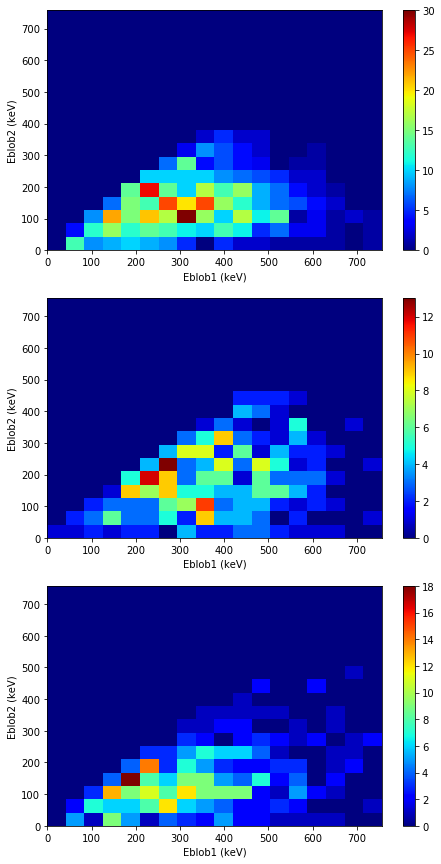

In [85]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 18

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(7.5);

# define intervals
eb1_low = 320000; eb1_high = 370000
eb2_low = 468000; eb2_high = 500000
eb3_low = 516600; eb3_high = 910000

# axes
ax_low = 15000; ax_high = 195000

# histogram range
hrange = 230000

# cuts
cuts_1 = ((l_etrk > eb1_low) & (l_etrk < eb1_high))
cuts_2 = ((l_etrk > eb2_low) & (l_etrk < eb2_high))
cuts_3 = ((l_etrk > eb3_low) & (l_etrk < eb3_high))

print("Number of events I1 ({0} keV, {1} keV): {2}".format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR,len(l_eblob1[cuts_1])))
print("Number of events I2 ({0} keV, {1} keV): {2}".format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR,len(l_eblob1[cuts_2])))
print("Number of events I3 ({0} keV, {1} keV): {2}".format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR,len(l_eblob1[cuts_3])))

# interval 1
ax1 = fig.add_subplot(311);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_1]*CAL_FACTOR, l_eblob2[cuts_1]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

# interval 2
ax2 = fig.add_subplot(312);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_2]*CAL_FACTOR, l_eblob2[cuts_2]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
extent2 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = ax2.imshow(hxy, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("Eblob1 (keV)")
ax2.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp2)

# interval 3
ax3 = fig.add_subplot(313);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_3]*CAL_FACTOR, l_eblob2[cuts_3]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
extent3 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp3 = ax3.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

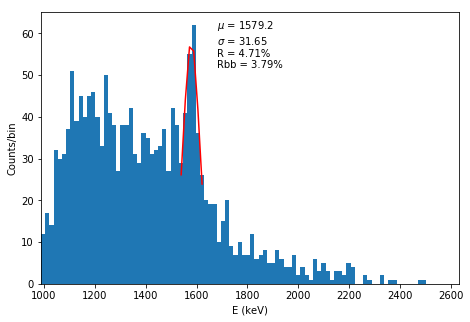

In [86]:
# track-energy spectrum
CAL_FACTOR = 1600/486000
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

#y, x, _ = plt.hist(ecorr_slice_spec, 100, range=[300000,800000])
y, x, _ = plt.hist(l_etrk[l_eblob2 > 100000]*CAL_FACTOR, 100, range=[300000*CAL_FACTOR,800000*CAL_FACTOR])

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 465e3*CAL_FACTOR, 495e3*CAL_FACTOR)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
plt.plot(x, f.fn(x), "r")
plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

#plt.hist(ecorr_slice_spec,bins=200)
#plt.ylim([100000,900000])
plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

In [ ]:
# Plot Eblob1 vs. Eblob2
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

Ecut_low_blobs = 0
Ecut_high_blobs = 301000

xcut_low = 15000
xcut_high = 285000

#cuts_blob = ((dist_cuts) & (l_dblobs > trklen_low))
#((l_etotcorr > Ecut_low) & (l_etotcorr < Ecut_high) & 
#             (l_eblob1 > Ecut_low_blobs) & (l_eblob2 < Ecut_high_blobs) & 
#             (l_dblobs > trklen_low))
cuts_blob = (l_eblob1 > Ecut_low_blobs) & (l_eblob2 < Ecut_high_blobs)
#print(l_hcindex[np.nonzero(cuts_blob & (l_eblob1 > 500))])
print("Number of events: {0}".format(len(l_eblob1[cuts_blob])))

# create the x-y projection
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_blob]*CAL_FACTOR, l_eblob2[cuts_blob]*CAL_FACTOR, normed=False, bins=(20, 20))
#hxy, xxy, yxy = np.histogram2d(l_eblob1, l_eblob2, normed=False, bins=(20, 20))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
#extent2 = [0, 200000, 0, 200000]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
plt.xlabel("Eblob1 (keV)")
plt.ylabel("Eblob2 (keV)")
plt.xlim([xcut_low*CAL_FACTOR,xcut_high*CAL_FACTOR])
plt.ylim([xcut_low*CAL_FACTOR,xcut_high*CAL_FACTOR])
#plt.xlim([Ecut_low_blobs,max(l_eblob2[cuts_blob])])
#plt.ylim([Ecut_low_blobs,max(l_eblob1[cuts_blob])])
plt.colorbar()

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(e_spec[l_eblob1 < 20000],bins=30,label='Single-track')
plt.hist(e_spec[l_eblob1 > 20000],bins=40,alpha=0.5,label='Double-track')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

In [ ]:
nevt = 30
hitc = hitc_evt[nevt]
print("Running Paolina for event {0} (event number {1}) with blob radius {2}".format(nevt,evtnum_hitc[nevt],blob_radius))

evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(nevt,evt_E))

voxels = plf.voxelize_hits(hitc,vox_size)
trks = plf.make_track_graphs(voxels,vox_size)
for t in trks:
    etrk = sum([vox.E for vox in t.nodes()])
    trk_energies.append(etrk)
itmax = np.argmax([len(t) for t in trks])
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

eblobs = plf.blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
if(len(eblobs) > 1):
    Eblob1, Eblob2 = next(iter_eblobs), next(iter_eblobs)
else:
    Eblob1 = Eblob2 = next(iter_eblobs)

# get the extremes
distances = plf.shortest_paths(trks[itmax])
exts = plf.find_extrema(distances)
iter_exts = iter(exts)
if(len(exts) > 1):
    a,b = next(iter_exts),next(iter_exts)
else:
    a = b = next(iter_exts)
    
# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
#for vv in trks[itmax]:
for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E)
    
vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132)
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2)
cbp2.set_label('Energy (Q)')
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2}) with energy {3}".format(a.pos[0],a.pos[1],a.pos[2],Eblob1))
print("Extreme1 at ({0},{1},{2}) with energy {3}".format(b.pos[0],b.pos[1],b.pos[2],Eblob2))

In [ ]:
# plot the clusters in 3D
carr_x = []; carr_y = []; carr_z = []; carr_c = []
for cc in hitc:
    if(cc.E > 1):
        carr_x.append(cc.X)
        carr_y.append(cc.Y)
        carr_z.append(cc.Z)
        carr_c.append(cc.E)

mcarr_x = []; mcarr_y = []; mcarr_z = []; mcarr_c = []
if(nevt < len(hitc_mc)):
    hitcm = hitc_mc[nevt]
    for cc in hitcm:
        mcarr_x.append(cc.X)
        mcarr_y.append(cc.Y)
        mcarr_z.append(cc.Z)
        mcarr_c.append(cc.E)

print(sum(mcarr_c))
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# true track
ax1 = fig.add_subplot(121, projection='3d')
sc3d = ax1.scatter(mcarr_x,mcarr_y,mcarr_z,marker='s',cmap='jet',c=mcarr_c)
xst, xen = ax1.get_xlim(); ax1.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax1.get_ylim(); ax1.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax1.get_zlim(); ax1.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_zlabel("z (mm)")
ax1.set_title("True Track")
lb_x = ax1.get_xticklabels()
lb_y = ax1.get_yticklabels()
lb_z = ax1.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (MeV)')

# reconstructed clusters
ax2 = fig.add_subplot(122, projection='3d')
sc3d = ax2.scatter(carr_x,carr_y,carr_z,marker='s',cmap='jet',c=carr_c)
xst, xen = ax2.get_xlim(); ax2.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax2.get_ylim(); ax2.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax2.get_zlim(); ax2.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")
ax2.set_zlabel("z (mm)")
ax2.set_title("Reconstructed Clusters")
lb_x = ax2.get_xticklabels()
lb_y = ax2.get_yticklabels()
lb_z = ax2.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (Q)')

# Paolina track
#ax3 = fig.add_subplot(133, projection='3d')
#sc3d = ax3.scatter(varr_x,varr_y,varr_z,marker='s',cmap='jet',c=varr_c)
#xst, xen = ax3.get_xlim(); ax3.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
#yst, yen = ax3.get_ylim(); ax3.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
#zst, zen = ax3.get_zlim(); ax3.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
#ax3.set_xlabel("x (mm)")
#ax3.set_ylabel("y (mm)")
#ax3.set_zlabel("z (mm)")
#ax3.set_title("Paolina Track")
#lb_x = ax3.get_xticklabels()
#lb_y = ax3.get_yticklabels()
#lb_z = ax3.get_zticklabels()
#for lb in (lb_x + lb_y + lb_z):
#    lb.set_fontsize(8.)
#cbp1 = plt.colorbar(sc3d)
#cbp1.set_label('Energy (Q)')

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(trk_energies,bins=200)
ax1.set_title("Paolina track energies")
ax1.set_xlabel("Energy (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_xlim([0,10000])
#ax2.set_yscale("log")

nn = 0
for ee,te in zip(evtnum_hitc,trk_energies):
    if(400 < te < 20000):
        print("Event {0} (number {1})".format(nn,ee))
    nn += 1

## Histograms from the Corona step

In [ ]:
# total charge
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(7.5);

# charge histogram
#ax1 = fig.add_subplot(121);
#plt.hist(l_qsipm,bins=200)
#ax1.set_title("Charge in all SiPMs in PMaps")
#ax1.set_xlabel("Charge (Q)")
#ax1.set_ylabel("Counts/bin")
#ax1.set_yscale("log")

# charge vs. cluster energy
ax2 = fig.add_subplot(111);
plt.scatter(l_qsipm_ccenter,l_qsipm_qcluster,marker='.',s=0.5)
ax2.set_title("Central charge of cluster vs. total charge of cluster")
ax2.set_xlabel("Central charge (Q)")
ax2.set_ylabel("Cluster charge (Q)")
#ax1.set_yscale("log")

In [ ]:
# cluster charges
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
plt.hist(l_qsipm_cluster,bins=200)
ax1.set_title("Charge in all SiPMs in clusters")
ax1.set_xlabel("Charge (Q)")
ax1.set_ylabel("Counts/bin")
ax1.set_yscale("log")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
#hxy, xxy, yxy = np.histogram2d(l_etotcorr[dist_cuts], l_zavg[dist_cuts], normed=False, bins=(30, 30))
#extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
#sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
plt.hist(l_qsipm_ccenter,bins=200)
ax2.set_title("Central cluster charge")
ax2.set_xlabel("Charge (Q)")
ax2.set_ylabel("Counts/bin")
ax2.set_yscale("log")

In [ ]:
# cluster charge vs. radial distance from local maxima
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# charge histogram
ax1 = fig.add_subplot(121);
#plt.scatter(l_r_rlm,l_q_rlm,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rlm, l_r_rlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp1 = plt.colorbar(sp1)
ax1.set_title("SiPM charge vs. radius from initial local maximum")
ax1.set_xlabel("Radial distance (mm)")
ax1.set_ylabel("SiPM charge")

# zoomed energy spectrum
ax2 = fig.add_subplot(122);
#plt.hist(l_etot[((l_etot > 60000) & (l_etot < 120000))],bins=50)
#plt.hist(l_etotcorr[((l_etotcorr > 60000) & (l_etotcorr < 120000))],bins=50)
#plt.scatter(l_zavg,l_etotcorr,marker='.')
hxy, xxy, yxy = np.histogram2d(l_q_rnlm, l_r_rnlm, normed=False, bins=(50, 50))
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = plt.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
cbp2 = plt.colorbar(sp2)
#plt.axvline(x=Ecut_low,color='red',linestyle='--')
#plt.axvline(x=Ecut_high,color='red',linestyle='--')
#plt.scatter(l_r_rnlm,l_q_rnlm,marker='.')
ax2.set_title("SiPM charge vs. radius from second local maximum")
ax2.set_xlabel("Radial distance (mm)")
ax2.set_ylabel("SiPM charge")

In [ ]:
# cluster charges
fig = plt.figure(4);
fig.set_figheight(15.0);
fig.set_figwidth(15.0);

# charge histograms for max clusters
for n in range(nccenters):
    splt_str = "32{0}".format(n+1)
    ax1 = fig.add_subplot(splt_str);
    plt.hist(l_qsipm_iccenter[n],bins=200)
    ax1.set_title("SiPM central charge for cluster {0}".format(n))
    ax1.set_xlabel("Charge (Q)")
    ax1.set_ylabel("Counts/bin")
    ax1.set_yscale("log")
    print("{0} entries for cluster {1}".format(len(l_qsipm_iccenter[n]),n))

# Old misc. code

In [ ]:
# plot a PMap slice
slice_no = 14
evt_no = 313
peak_no = 0

filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_0_0_7bar_pmaps_10000.root.h5"
try:
    S1s, S2s, S2Sis = load_pmaps(filename)
except (ValueError, tb.exceptions.NoSuchNodeError):
    print("Empty file {0}. Skipping.".format(ifile))

S2 = S2s  .get(evt_no, {})
S1 = S1s  .get(evt_no, {})
Si = S2Sis.get(evt_no, {})
si = Si[peak_no]

t, e = next(iter(S1.values()))
S1t  = t[np.argmax(e)]

t_slice = S2[0][0][slice_no]
z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0

clusters = compute_xy_position(si, slice_no)
print("Found {0} clusters".format(len(clusters)))

x0vals = []; y0vals = []
for c in clusters:
    x0vals.append(c.pos[0])
    y0vals.append(c.pos[1])
    print("cluster ({0},{1},{2})".format(c.pos[0],c.pos[1],z))
    
xvals = []; yvals = []; qvals = []
for s in si.items():
    xvals.append(data_xs[s[0]])
    yvals.append(data_ys[s[0]])
    qvals.append(s[1][slice_no])
    #print(s[1])
    
plot_test_event(xvals,yvals,qvals,x0vals,y0vals)

# Plot the generated correction factors

In [ ]:
corr_file_MC = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/mcKr.corr"
corr_file_data_dnn = "/Users/jrenner/IFIC/IC-1/invisible_cities/cities/corr_r4236.h5" 
corr_file_data = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b30.corr"
fcorr_MC = tb.open_file(corr_file_MC,'r')
fcorr_data = tb.open_file(corr_file_data,'r')
fcorr_data_dnn = tb.open_file(corr_file_data_dnn,'r')

mcorr_x = []; mcorr_y = []; mcorr_fs = []; mcorr_us = []; mcorr_nevt = []
mxyc = fcorr_MC.root.Corrections.XYcorrections
for r in range(len(mxyc)):
    mcorr_x.append(mxyc[r]['x'])
    mcorr_y.append(mxyc[r]['y'])
    mcorr_fs.append(mxyc[r]['factor'])
    mcorr_us.append(mxyc[r]['uncertainty'])
    mcorr_nevt.append(mxyc[r]['nevt'])
mcorr_x = np.array(mcorr_x)
mcorr_y = np.array(mcorr_y)
mcorr_fs = np.array(mcorr_fs)
mcorr_us = np.array(mcorr_us)
mcorr_nevt = np.array(mcorr_nevt)
maxf_mc = np.max(mcorr_fs)
print("Total MC stats = {0}".format(np.sum(mcorr_nevt)))

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr_data.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf_data = np.max(corr_fs)
print("Total data stats = {0}".format(np.sum(corr_nevt)))

dcorr_x = []; dcorr_y = []; dcorr_fs = []; dcorr_us = []; dcorr_nevt = []
dxyc = fcorr_data_dnn.root.Corrections.XYcorrections
for r in range(len(dxyc)):
    dcorr_x.append(dxyc[r]['x'])
    dcorr_y.append(dxyc[r]['y'])
    dcorr_fs.append(dxyc[r]['factor'])
    dcorr_us.append(dxyc[r]['uncertainty'])
    dcorr_nevt.append(dxyc[r]['nevt'])
dcorr_x = np.array(dcorr_x)
dcorr_y = np.array(dcorr_y)
dcorr_fs = np.array(dcorr_fs)
dcorr_us = np.array(dcorr_us)
dcorr_nevt = np.array(dcorr_nevt)
maxf_data_dnn = np.max(dcorr_fs)
print("Total data DNN stats = {0}".format(np.sum(dcorr_nevt)))

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(18.0);

# correction factor (MC)
ax1 = fig.add_subplot(331);
ax1.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax1.set_title("Correction factor (MC, DST)")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(332)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error (MC, DST)")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(333)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events (MC, DST)")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

ax4 = fig.add_subplot(334)
ax4.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax4.set_title("Correction factor (run 4236, DST)")
ax4.set_xlabel("x (mm)")
ax4.set_ylabel("y (mm)")

ax5 = fig.add_subplot(335)
ax5.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax5.set_title("Correction factor error (run 4236, DST)")
ax5.set_xlabel("x (mm)")
ax5.set_ylabel("y (mm)")

ax6 = fig.add_subplot(336)
ax6.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax6.set_title("Correction factor # events (run 4236, DST)")
ax6.set_xlabel("x (mm)")
ax6.set_ylabel("y (mm)")

ax7 = fig.add_subplot(337)
ax7.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_data_dnn,maxf_mc,maxf_data))
plt.colorbar()
ax7.set_title("Correction factor (run 4236, DNN)")
ax7.set_xlabel("x (mm)")
ax7.set_ylabel("y (mm)")

ax8 = fig.add_subplot(338)
ax8.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_us, cmap='jet')
plt.colorbar()
ax8.set_title("Correction factor error (run 4236, DNN)")
ax8.set_xlabel("x (mm)")
ax8.set_ylabel("y (mm)")

ax9 = fig.add_subplot(339)
ax9.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_nevt, cmap='jet')
plt.colorbar()
ax9.set_title("Correction factor # events (run 4236, DNN)")
ax9.set_xlabel("x (mm)")
ax9.set_ylabel("y (mm)")

#ax1 = fig.add_subplot(121);
#extent1 = [-215., 215., -215., 215]
#sp2 = plt.imshow(h2d, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)
#ax2 = fig.add_subplot(122)
#sp2 = plt.imshow(h2d_err, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)

fcorr_MC.close()
fcorr_data.close()

In [ ]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236.corr"
fcorr = tb.open_file(corr_file,'r')

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
    
fig = plt.figure(4);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor fs
ax1 = fig.add_subplot(121);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(122)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us)
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

In [ ]:
# Initial look at run 4264
fn = tb.open_file('/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4264/dst/dst_4264.root.h5','r')

# plot the S2 spectrum
s2arr = fn.root.DST.Events[:]['S2e']

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(s2arr,bins=500)
lnd = plt.legend(loc=1)
plt.xlabel('Energy')
plt.ylabel('Counts/bin')
#plt.xlim([1000,40000])

In [ ]:
# run Paolina for many events
trk_energies = [];
l_eblob1 = []; l_eblob2 = []
for nevt in range(len(hitc_evt)):
#for nevt in range(1000):
    
    hitc = hitc_evt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[nevt]])
    if(len(hitc_evt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_evt[nevt]])/np.exp(-evt_Z/tlife)
    
    # Make energy and radial cuts.
    if(not (evt_Ecorrtau_xy_slice > ECCUT_LOW and evt_Ecorrtau_xy_slice < ECCUT_HIGH) or evt_R >= 150.):
        continue
        
    #for h in hitc:
    #    print("Hit ({0},{1},{2},{3})".format(h.pos[0],h.pos[1],h.pos[2],h.E))
    #print("Event {0} with total energy {1}".format(nevt,evt_E))

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    itmax = np.argmax([len(t) for t in trks])
    if(len(trks[itmax])/len(voxels) < 0.95):
        continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_evt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add distribution information (event-scale)
    l_eblob1.append(Eblob1)
    l_eblob2.append(Eblob2)
    
l_eblob1.append(250000)
l_eblob2.append(250000)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)